In [5]:
!pip install librosa soundfile matplotlib seaborn scikit-learn umap-learn

In [6]:
!pip install torch torchvision torchaudio

### Import required models

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
import librosa
warnings.filterwarnings('ignore')

# Memory optimization
import gc
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Using device: cuda


### Raw Audio Loading and Resampling

In [8]:

from google.colab import drive
drive.mount('/content/drive')

# Update these paths
AUDIO_PATH = '/content/drive/MyDrive/wmms_audio/'
LABELS_PATH = '/content/drive/MyDrive/wmms_labels.csv'

# Load labels
labels_df = pd.read_csv(LABELS_PATH)
print(f"Dataset shape: {labels_df.shape}")
print(f"\nFirst few rows:")
print(labels_df.head())
print(f"\nClass distribution:")
print(labels_df['species'].value_counts())

# Encode labels
le = LabelEncoder()
labels_df['label_encoded'] = le.fit_transform(labels_df['species'])
num_classes = len(le.classes_)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {le.classes_}")


Mounted at /content/drive
Dataset shape: (1357, 4)

First few rows:
             file             species  label_id  duration_sec
0  clip_00000.wav     Spinner_Dolphin        26           NaN
1  clip_00001.wav        Bearded_Seal         1           NaN
2  clip_00002.wav        Weddell_Seal        29           NaN
3  clip_00003.wav           Harp_Seal        11           NaN
4  clip_00004.wav  False_Killer_Whale         7           NaN

Class distribution:
species
Spinner_Dolphin                     91
Frasers_Dolphin                     69
Striped_Dolphin                     65
Sperm_Whale                         60
Long-Finned_Pilot_Whale             56
Grampus,_Rissos_Dolphin             54
Pantropical_Spotted_Dolphin         53
Short-Finned_Pacific_Pilot_Whale    53
Humpback_Whale                      51
Clymene_Dolphin                     50
Melon_Headed_Whale                  50
Bowhead_Whale                       48
False_Killer_Whale                  47
White-beaked_Dolphin    

###Mel-Spectrogram Feature Extraction

In [9]:
# Balanced parameters - quality + efficiency
SR = 22050  # Keep high quality
N_MELS = 96  # Balanced resolution
SPEC_LENGTH = 112  # Balanced time dimension
N_FFT = 2048  # Keep high resolution
HOP_LENGTH = 512  # Standard value
AUDIO_LENGTH = 66150  # ~3 seconds at 22050 Hz

def load_audio(file_path, sr=SR, duration=None):
    """Load audio file"""
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def audio_to_spectrogram(audio, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Convert audio to mel-spectrogram"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def pad_or_truncate_spectrogram(spec, target_length=SPEC_LENGTH):
    """Ensure all spectrograms have same time dimension"""
    if spec.shape[1] < target_length:
        pad_width = target_length - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
    elif spec.shape[1] > target_length:
        spec = spec[:, :target_length]
    return spec

def pad_or_truncate_audio(audio, target_length=AUDIO_LENGTH):
    """Ensure all audio clips have same length"""
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
    elif len(audio) > target_length:
        audio = audio[:target_length]
    return audio

In [10]:

print("\nProcessing audio files and creating spectrograms...")

spectrograms = []
raw_audios = []
labels = []
failed_files = []

# Process in batches to manage memory
batch_size = 80
for i in range(0, len(labels_df), batch_size):
    batch_files = labels_df.iloc[i:i+batch_size]

    for idx, row in batch_files.iterrows():
        file_path = os.path.join(AUDIO_PATH, row['file'])

        if not os.path.exists(file_path):
            failed_files.append(row['file'])
            continue

        # Load audio
        audio = load_audio(file_path, sr=SR)
        if audio is None:
            failed_files.append(row['file'])
            continue

        # Create spectrogram
        spec = audio_to_spectrogram(audio, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        spec = pad_or_truncate_spectrogram(spec, SPEC_LENGTH)

        # Pad/truncate raw audio
        audio_padded = pad_or_truncate_audio(audio, AUDIO_LENGTH)

        spectrograms.append(spec)
        raw_audios.append(audio_padded)
        labels.append(row['label_encoded'])

    # Memory management
    if (i // batch_size) % 2 == 0:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"Processed {min(i+batch_size, len(labels_df))}/{len(labels_df)} files")

print(f"\nSuccessfully processed: {len(spectrograms)} files")
print(f"Failed files: {len(failed_files)}")

# Convert to numpy arrays
spectrograms = np.array(spectrograms)
raw_audios = np.array(raw_audios)
labels = np.array(labels)

print(f"\nSpectrograms shape: {spectrograms.shape}")
print(f"Raw audios shape: {raw_audios.shape}")
print(f"Labels shape: {labels.shape}")



Processing audio files and creating spectrograms...
Processed 80/1357 files
Processed 160/1357 files
Processed 240/1357 files
Processed 320/1357 files
Processed 400/1357 files
Processed 480/1357 files
Processed 560/1357 files
Processed 640/1357 files
Processed 720/1357 files
Processed 800/1357 files
Processed 880/1357 files
Processed 960/1357 files
Processed 1040/1357 files
Processed 1120/1357 files
Processed 1200/1357 files
Processed 1280/1357 files
Processed 1357/1357 files

Successfully processed: 1357 files
Failed files: 0

Spectrograms shape: (1357, 96, 112)
Raw audios shape: (1357, 66150)
Labels shape: (1357,)


### Dataset Splitting

In [11]:
# Split data: 70% train, 15% validation, 15% test
X_train_spec, X_temp_spec, y_train, y_temp = train_test_split(
    spectrograms, labels, test_size=0.3, random_state=42, stratify=labels
)

# Second split (validation/test) - non-stratified
X_val_spec, X_test_spec, y_val, y_test = train_test_split(
    X_temp_spec, y_temp, test_size=0.5, random_state=42
)

# Split raw audio data similarly
X_train_audio, X_temp_audio, _, _ = train_test_split(
    raw_audios, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val_audio, X_test_audio, _, _ = train_test_split(
    X_temp_audio, y_temp, test_size=0.5, random_state=42
)

print(f"\nTrain set: {X_train_spec.shape[0]} samples")
print(f"Validation set: {X_val_spec.shape[0]} samples")
print(f"Test set: {X_test_spec.shape[0]} samples")



Train set: 949 samples
Validation set: 204 samples
Test set: 204 samples


In [12]:

class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.FloatTensor(spectrograms).unsqueeze(1)  # Add channel dim
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

class AudioDataset(Dataset):
    def __init__(self, audios, labels):
        self.audios = torch.FloatTensor(audios).unsqueeze(1)  # Add channel dim
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.audios[idx], self.labels[idx]

# Create datasets
train_dataset_spec = SpectrogramDataset(X_train_spec, y_train)
val_dataset_spec = SpectrogramDataset(X_val_spec, y_val)
test_dataset_spec = SpectrogramDataset(X_test_spec, y_test)

train_dataset_audio = AudioDataset(X_train_audio, y_train)
val_dataset_audio = AudioDataset(X_val_audio, y_val)
test_dataset_audio = AudioDataset(X_test_audio, y_test)

# Create dataloaders
BATCH_SIZE = 32

train_loader_spec = DataLoader(train_dataset_spec, batch_size=BATCH_SIZE, shuffle=True)
val_loader_spec = DataLoader(val_dataset_spec, batch_size=BATCH_SIZE)
test_loader_spec = DataLoader(test_dataset_spec, batch_size=BATCH_SIZE)

train_loader_audio = DataLoader(train_dataset_audio, batch_size=BATCH_SIZE, shuffle=True)
val_loader_audio = DataLoader(val_dataset_audio, batch_size=BATCH_SIZE)
test_loader_audio = DataLoader(test_dataset_audio, batch_size=BATCH_SIZE)


gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


### Baseline Architectures (Task 1-6)

In [13]:
# TASK 1: Deep Neural Network (DNN)
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [14]:

# TASK 2: Convolutional Neural Network (CNN)
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(48, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(96, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((6, 7))
        )
        self.classifier = nn.Linear(256 * 6 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [15]:

# TASK 3: Recurrent Neural Network (RNN)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, n_mels, time) -> (batch, time, n_mels)
        x = x.squeeze(1).transpose(1, 2)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [16]:
# TASK 4: Long Short-Term Memory (LSTM)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, n_mels, time) -> (batch, time, n_mels)
        x = x.squeeze(1).transpose(1, 2)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [17]:

# TASK 5: Transformer
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_classes, d_model=192, nhead=6, num_layers=3):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, SPEC_LENGTH, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=384, dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, n_mels, time) -> (batch, time, n_mels)
        x = x.squeeze(1).transpose(1, 2)
        x = self.embedding(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = x.transpose(0, 1)  # (time, batch, d_model)
        x = self.transformer(x)
        x = x.mean(dim=0)  # Global average pooling
        x = self.fc(x)
        return x


In [18]:

# TASK 6: Raw Audio CNN (1D Convolutions)
class RawAudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(RawAudioCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=80, stride=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(8)
        )
        self.classifier = nn.Linear(256 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### Model Training Functions

In [19]:
def evaluate_model(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)             # logits
            loss += criterion(outputs, targets).item()
            probs = torch.softmax(outputs, dim=1)

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    if len(loader) == 0:
        return 0.0, 0.0, np.array([]), np.array([]), np.array([])

    return (
        loss / len(loader),
        100. * correct / total,
        np.array(all_preds),
        np.array(all_labels),
        np.array(all_probs)
    )

def train_and_evaluate(model, model_name, train_loader, val_loader, test_loader, epochs=30):
    print(f"\n=== Training {model_name} ===")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0
    patience = 8
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total if total > 0 else 0.0
        train_losses.append(train_loss / max(1, len(train_loader)))
        train_accs.append(train_acc)

        # Validation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Load best model and test
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_model(model, test_loader, criterion)

    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    return {
        'model': model_name,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'predictions': test_preds,
        'true_labels': test_labels,
        'probabilities': test_probs,
        'train_history': (train_losses, train_accs, val_losses, val_accs)
    }

### Accuracy & ROC plotting functions


In [20]:
def plot_accuracy_curves(results, model_name):
    """Plot Train vs Validation Accuracy Curves"""

    train_losses, train_accs, val_losses, val_accs = results[model_name]['train_history']

    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(results, model_name, num_classes):
    """Plot One-vs-Rest Multi-Class ROC Curves with Proper Spacing"""

    if 'probabilities' not in results[model_name]:
        print(f"No probability scores found for {model_name} (ROC Skipped)")
        return

    y_true = results[model_name]['true_labels']
    y_prob = results[model_name]['probabilities']

    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    plt.figure(figsize=(16, 12))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr, tpr, linewidth=2,
            label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})'
        )

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - Multi-Class ROC Curves', fontsize=14, pad=15)

    plt.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=9,
        frameon=True
    )

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



###Train All Baseline Models

In [21]:
results = {}

# Calculate input sizes
spec_height = N_MELS        # 96
spec_width  = SPEC_LENGTH  # 112

dnn_input_size = spec_height * spec_width


=== Training DNN ===
Epoch 1/25: Train Loss: 3.0328, Train Acc: 16.02% | Val Loss: 2.6901, Val Acc: 25.00%
Epoch 2/25: Train Loss: 2.5670, Train Acc: 26.77% | Val Loss: 2.4292, Val Acc: 33.33%
Epoch 3/25: Train Loss: 2.3437, Train Acc: 33.51% | Val Loss: 2.2476, Val Acc: 35.78%
Epoch 4/25: Train Loss: 2.1393, Train Acc: 38.15% | Val Loss: 2.1051, Val Acc: 39.71%
Epoch 5/25: Train Loss: 2.0554, Train Acc: 39.94% | Val Loss: 1.9876, Val Acc: 46.08%
Epoch 6/25: Train Loss: 1.9070, Train Acc: 44.78% | Val Loss: 1.9395, Val Acc: 42.65%
Epoch 7/25: Train Loss: 1.8630, Train Acc: 43.52% | Val Loss: 1.8693, Val Acc: 46.57%
Epoch 8/25: Train Loss: 1.7702, Train Acc: 46.89% | Val Loss: 1.8203, Val Acc: 47.06%
Epoch 9/25: Train Loss: 1.7042, Train Acc: 48.26% | Val Loss: 1.7912, Val Acc: 45.10%
Epoch 10/25: Train Loss: 1.6434, Train Acc: 51.00% | Val Loss: 1.7807, Val Acc: 45.59%
Epoch 11/25: Train Loss: 1.5713, Train Acc: 53.64% | Val Loss: 1.7389, Val Acc: 50.49%
Epoch 12/25: Train Loss: 1.505

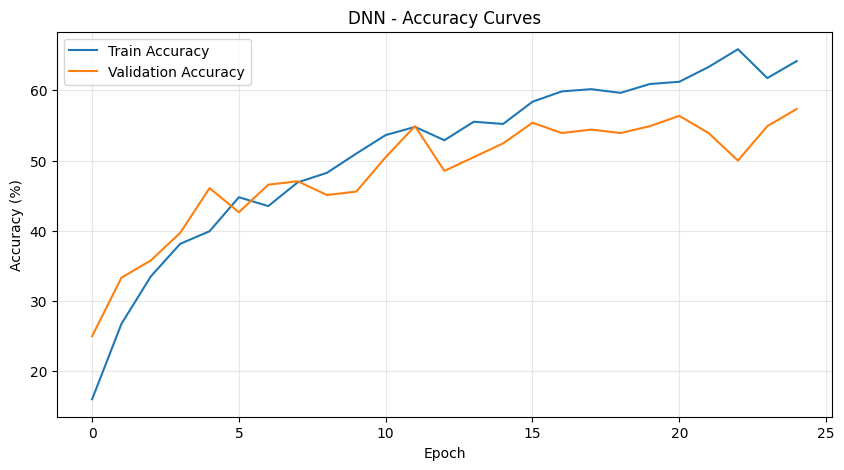

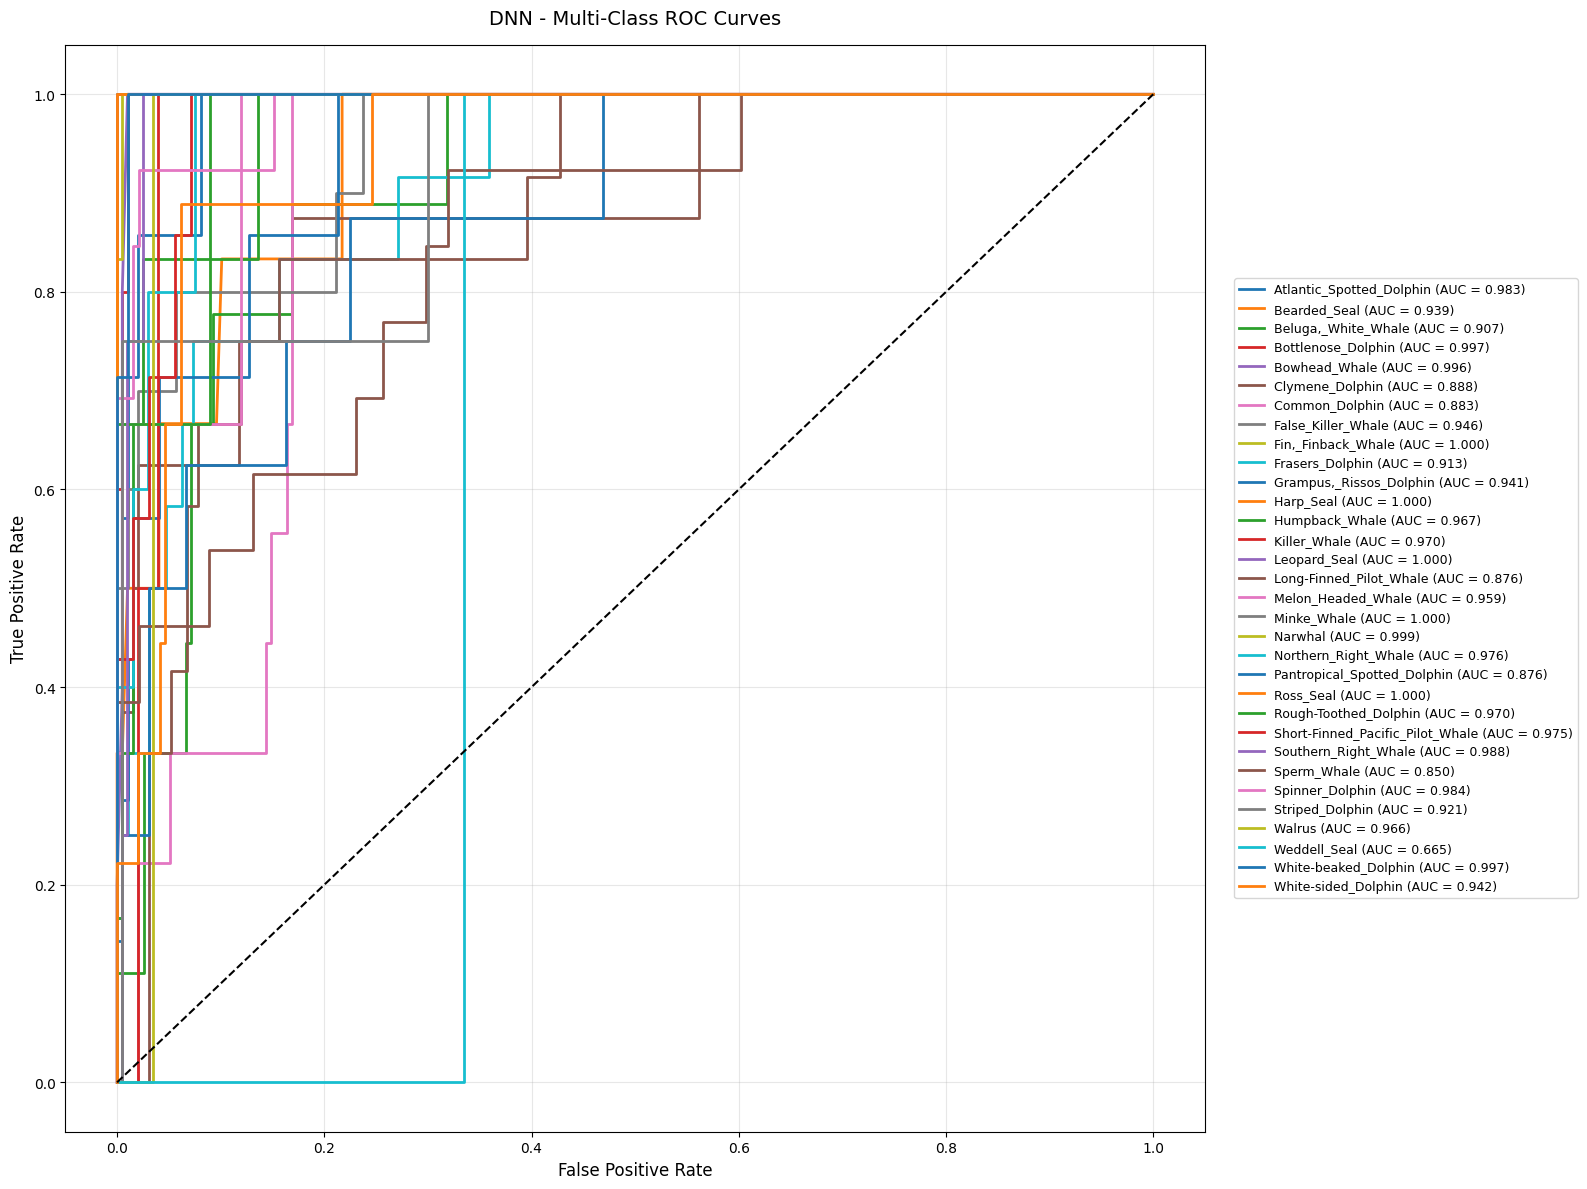

In [22]:
model_dnn = DNN(dnn_input_size, num_classes).to(device)

results['DNN'] = train_and_evaluate(
    model_dnn, "DNN",
    train_loader_spec,
    val_loader_spec,
    test_loader_spec,
    epochs=25
)

plot_accuracy_curves(results, "DNN")
plot_multiclass_roc(results, "DNN", num_classes)



=== Training CNN ===
Epoch 1/25: Train Loss: 3.2260, Train Acc: 24.55% | Val Loss: 2.3560, Val Acc: 38.24%
Epoch 2/25: Train Loss: 1.7219, Train Acc: 48.58% | Val Loss: 1.5574, Val Acc: 53.92%
Epoch 3/25: Train Loss: 1.2601, Train Acc: 61.54% | Val Loss: 1.7156, Val Acc: 57.84%
Epoch 4/25: Train Loss: 0.9931, Train Acc: 69.02% | Val Loss: 1.4007, Val Acc: 59.80%
Epoch 5/25: Train Loss: 0.8075, Train Acc: 74.50% | Val Loss: 1.3741, Val Acc: 63.73%
Epoch 6/25: Train Loss: 0.6371, Train Acc: 80.30% | Val Loss: 1.3517, Val Acc: 64.71%
Epoch 7/25: Train Loss: 0.5112, Train Acc: 84.62% | Val Loss: 1.0999, Val Acc: 72.55%
Epoch 8/25: Train Loss: 0.4201, Train Acc: 87.67% | Val Loss: 1.4459, Val Acc: 67.65%
Epoch 9/25: Train Loss: 0.4271, Train Acc: 86.62% | Val Loss: 1.4204, Val Acc: 68.14%
Epoch 10/25: Train Loss: 0.3197, Train Acc: 88.94% | Val Loss: 1.3957, Val Acc: 62.25%
Epoch 11/25: Train Loss: 0.1791, Train Acc: 94.52% | Val Loss: 1.1131, Val Acc: 70.59%
Epoch 12/25: Train Loss: 0.192

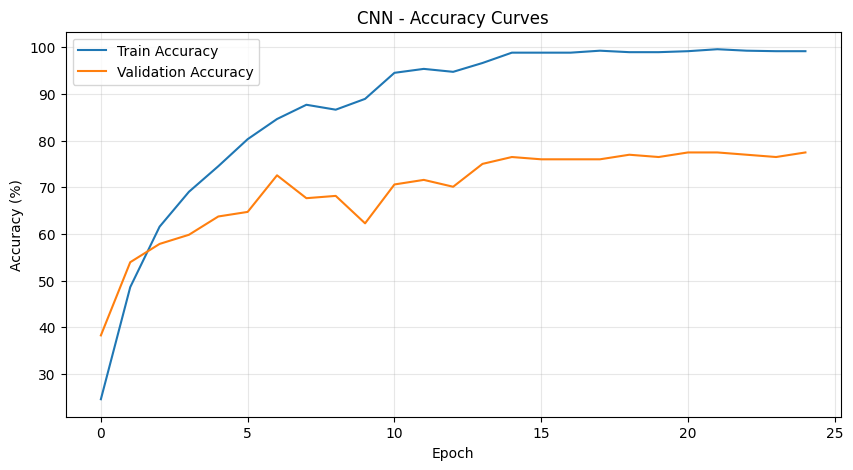

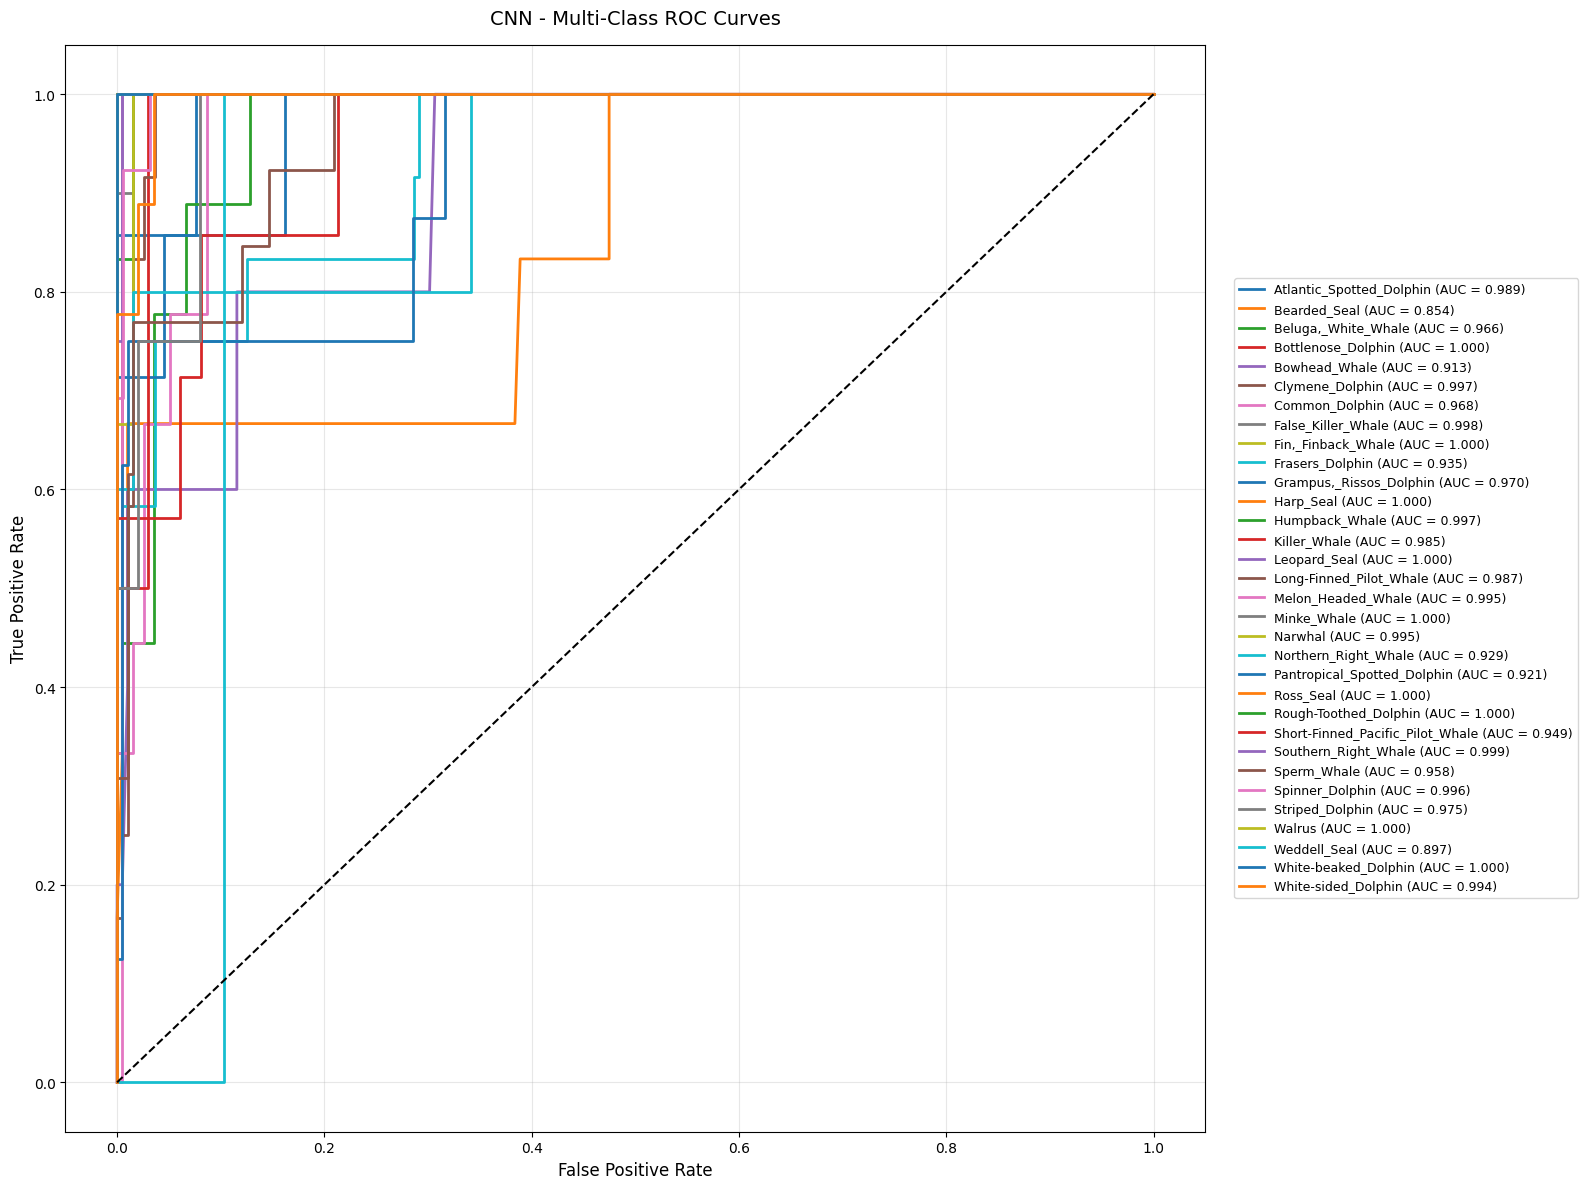

In [23]:
model_cnn = CNN(num_classes).to(device)

results['CNN'] = train_and_evaluate(
    model_cnn, "CNN",
    train_loader_spec,
    val_loader_spec,
    test_loader_spec,
    epochs=25
)

plot_accuracy_curves(results, "CNN")
plot_multiclass_roc(results, "CNN", num_classes)



=== Training RNN ===
Epoch 1/25: Train Loss: 3.3098, Train Acc: 8.54% | Val Loss: 3.1625, Val Acc: 11.76%
Epoch 2/25: Train Loss: 3.1867, Train Acc: 11.17% | Val Loss: 3.1247, Val Acc: 14.71%
Epoch 3/25: Train Loss: 3.1301, Train Acc: 13.07% | Val Loss: 3.0269, Val Acc: 15.69%
Epoch 4/25: Train Loss: 3.1863, Train Acc: 11.49% | Val Loss: 3.0100, Val Acc: 19.12%
Epoch 5/25: Train Loss: 3.3526, Train Acc: 11.38% | Val Loss: 3.3456, Val Acc: 4.90%
Epoch 6/25: Train Loss: 3.0508, Train Acc: 14.23% | Val Loss: 3.0038, Val Acc: 19.12%
Epoch 7/25: Train Loss: 3.2268, Train Acc: 13.59% | Val Loss: 3.1872, Val Acc: 14.71%
Epoch 8/25: Train Loss: 3.1230, Train Acc: 15.17% | Val Loss: 3.0771, Val Acc: 15.69%
Epoch 9/25: Train Loss: 3.0384, Train Acc: 16.23% | Val Loss: 2.9706, Val Acc: 16.18%
Epoch 10/25: Train Loss: 2.9912, Train Acc: 16.97% | Val Loss: 3.0373, Val Acc: 14.71%
Epoch 11/25: Train Loss: 2.9663, Train Acc: 16.12% | Val Loss: 2.9558, Val Acc: 15.69%
Epoch 12/25: Train Loss: 2.9437,

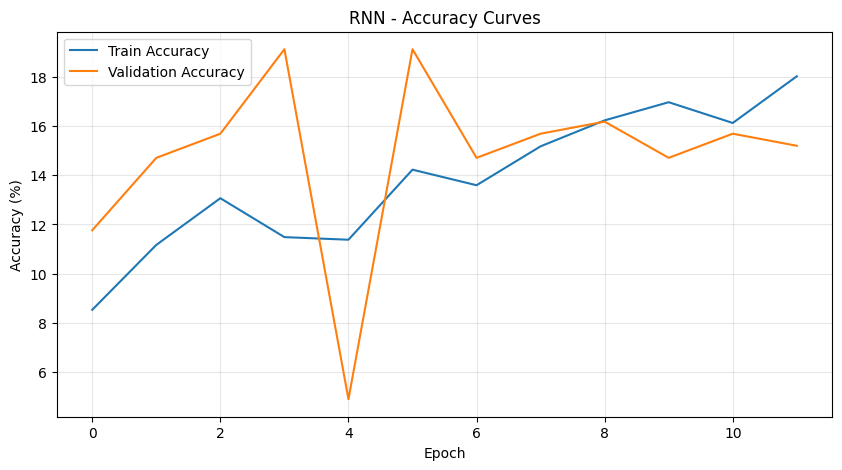

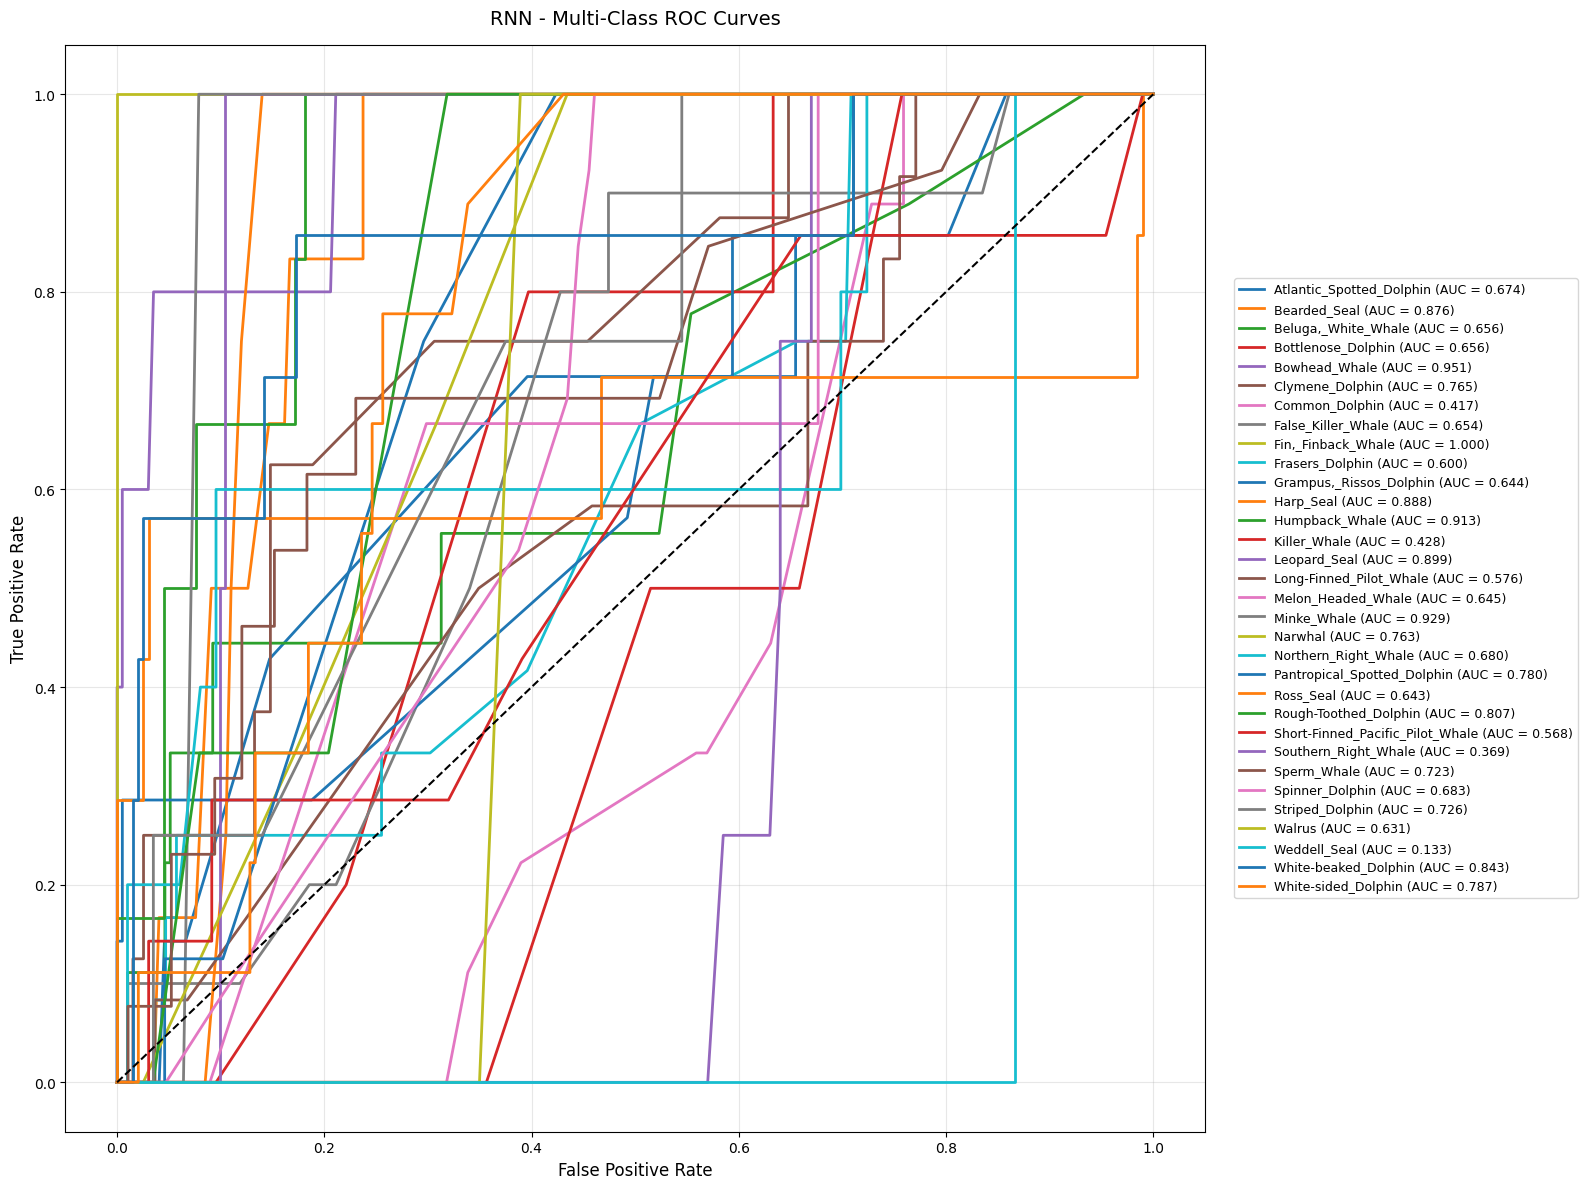

In [24]:
# Task 3: RNN
model_rnn = RNN(
    input_size=spec_height,
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes
).to(device)

results['RNN'] = train_and_evaluate(
    model_rnn,
    "RNN",
    train_loader_spec,
    val_loader_spec,
    test_loader_spec,
    25
)
plot_accuracy_curves(results, "RNN")
plot_multiclass_roc(results, "RNN", num_classes)



=== Training LSTM ===
Epoch 1/25: Train Loss: 3.3500, Train Acc: 10.64% | Val Loss: 3.1259, Val Acc: 13.73%
Epoch 2/25: Train Loss: 3.0636, Train Acc: 16.23% | Val Loss: 3.0150, Val Acc: 15.20%
Epoch 3/25: Train Loss: 3.0408, Train Acc: 14.33% | Val Loss: 3.0264, Val Acc: 14.22%
Epoch 4/25: Train Loss: 2.9825, Train Acc: 15.07% | Val Loss: 2.9698, Val Acc: 15.69%
Epoch 5/25: Train Loss: 3.0209, Train Acc: 13.17% | Val Loss: 2.9789, Val Acc: 15.69%
Epoch 6/25: Train Loss: 3.0288, Train Acc: 13.80% | Val Loss: 2.9113, Val Acc: 19.12%
Epoch 7/25: Train Loss: 2.9682, Train Acc: 17.18% | Val Loss: 3.0699, Val Acc: 18.14%
Epoch 8/25: Train Loss: 3.0070, Train Acc: 15.07% | Val Loss: 3.0762, Val Acc: 13.24%
Epoch 9/25: Train Loss: 2.9411, Train Acc: 14.44% | Val Loss: 2.8807, Val Acc: 20.59%
Epoch 10/25: Train Loss: 2.8826, Train Acc: 17.07% | Val Loss: 2.8473, Val Acc: 21.08%
Epoch 11/25: Train Loss: 2.9531, Train Acc: 16.65% | Val Loss: 2.9959, Val Acc: 17.65%
Epoch 12/25: Train Loss: 2.84

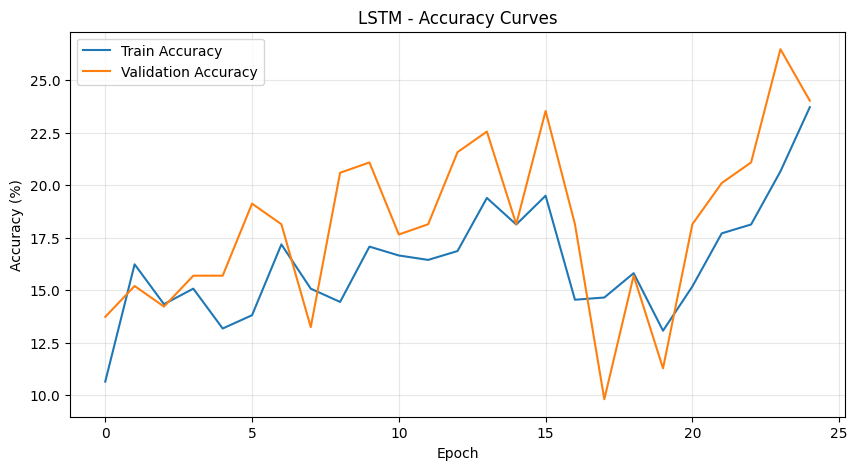

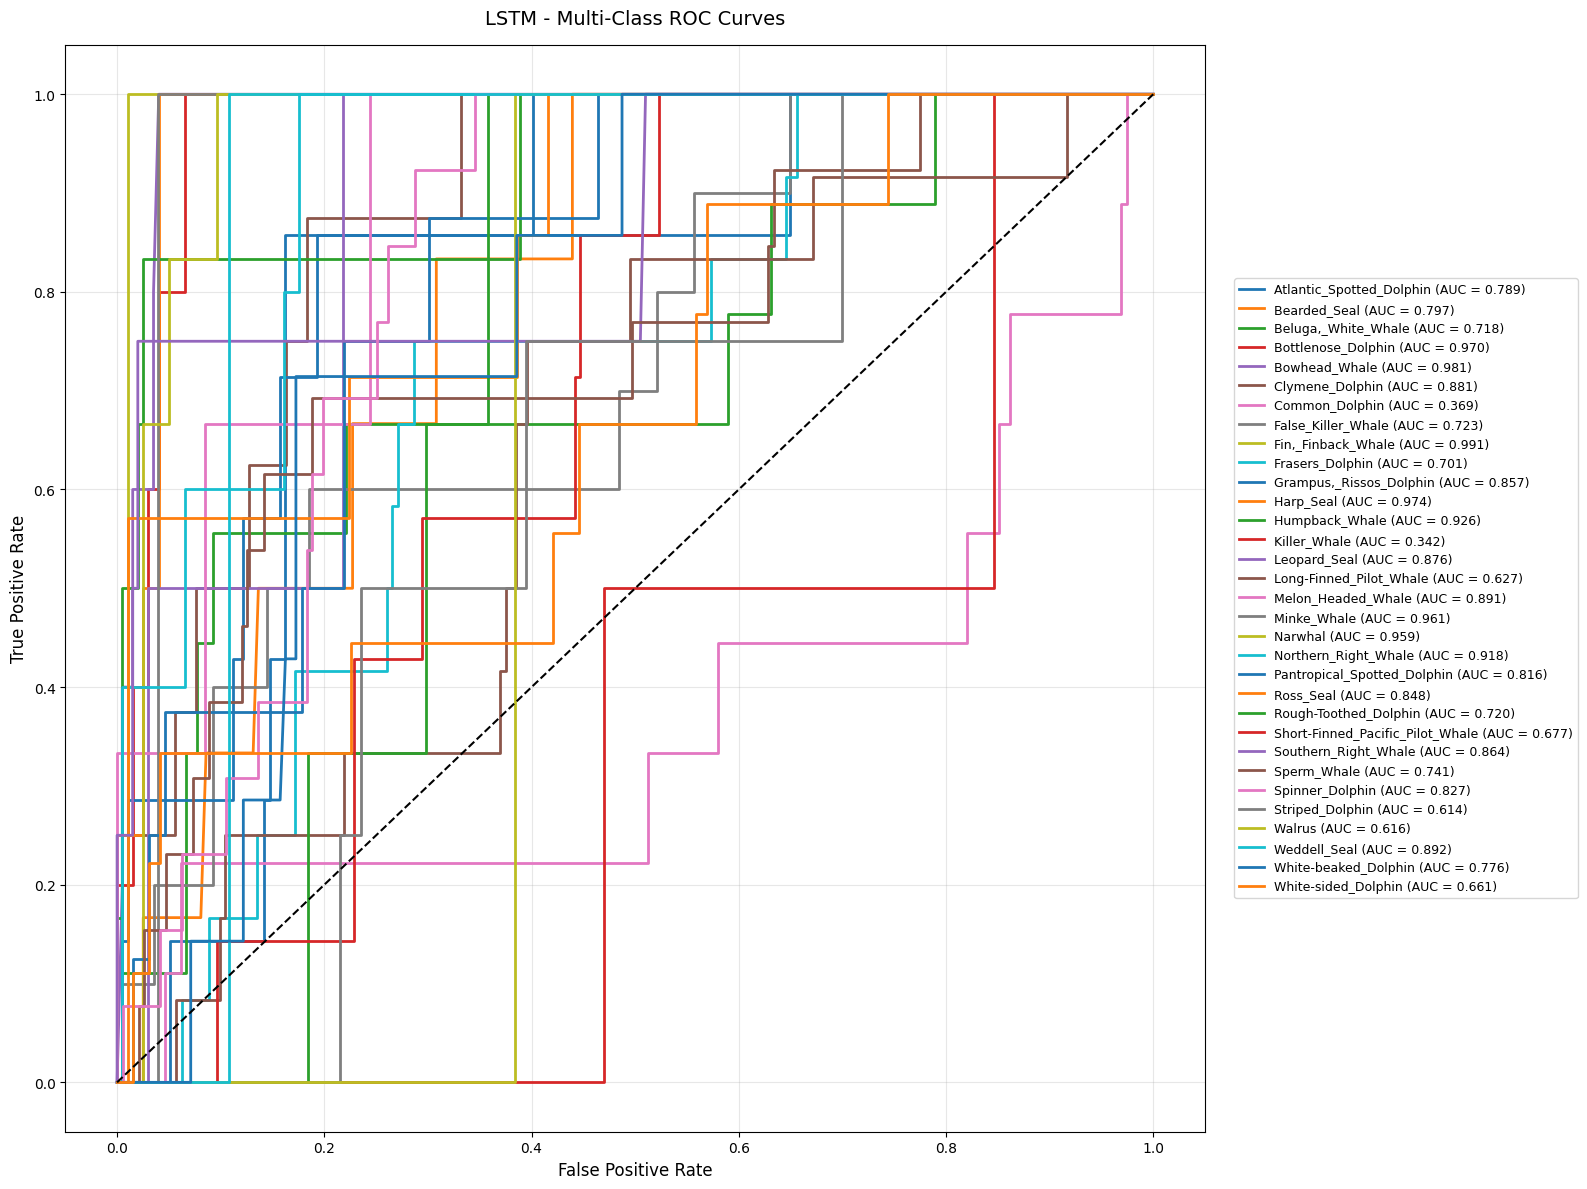

In [25]:
model_lstm = LSTM(
    input_size=spec_height,
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes).to(device)

results['LSTM'] = train_and_evaluate(
    model_lstm,
    "LSTM",
    train_loader_spec,
    val_loader_spec,
    test_loader_spec,
    25
)
plot_accuracy_curves(results, "LSTM")
plot_multiclass_roc(results, "LSTM", num_classes)


=== Training Transformer ===
Epoch 1/25: Train Loss: 3.0851, Train Acc: 13.91% | Val Loss: 2.6221, Val Acc: 26.47%
Epoch 2/25: Train Loss: 2.3702, Train Acc: 33.19% | Val Loss: 2.2324, Val Acc: 37.75%
Epoch 3/25: Train Loss: 2.1303, Train Acc: 37.30% | Val Loss: 1.9947, Val Acc: 41.18%
Epoch 4/25: Train Loss: 1.8524, Train Acc: 45.42% | Val Loss: 1.9052, Val Acc: 45.10%
Epoch 5/25: Train Loss: 1.5816, Train Acc: 52.58% | Val Loss: 1.6500, Val Acc: 54.41%
Epoch 6/25: Train Loss: 1.5045, Train Acc: 53.74% | Val Loss: 1.5497, Val Acc: 54.90%
Epoch 7/25: Train Loss: 1.3382, Train Acc: 60.06% | Val Loss: 1.4347, Val Acc: 53.92%
Epoch 8/25: Train Loss: 1.2029, Train Acc: 63.75% | Val Loss: 1.5587, Val Acc: 54.41%
Epoch 9/25: Train Loss: 1.2163, Train Acc: 61.64% | Val Loss: 1.6073, Val Acc: 53.92%
Epoch 10/25: Train Loss: 1.0891, Train Acc: 67.44% | Val Loss: 1.3378, Val Acc: 59.31%
Epoch 11/25: Train Loss: 0.9662, Train Acc: 68.91% | Val Loss: 1.1577, Val Acc: 62.25%
Epoch 12/25: Train Los

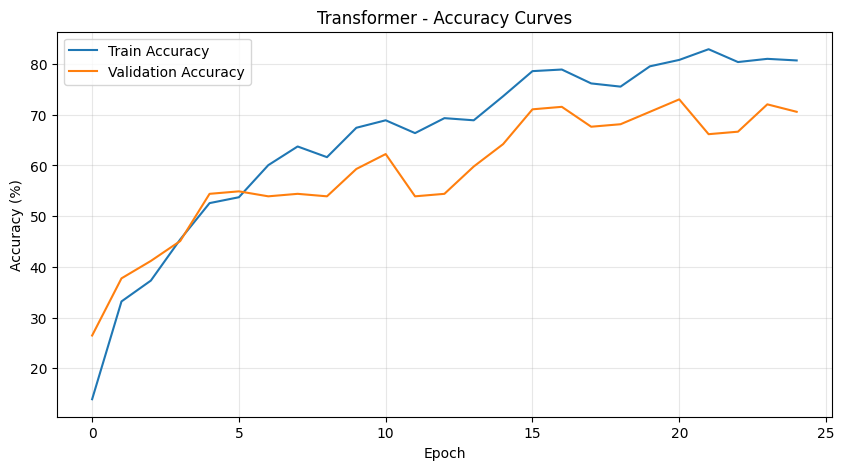

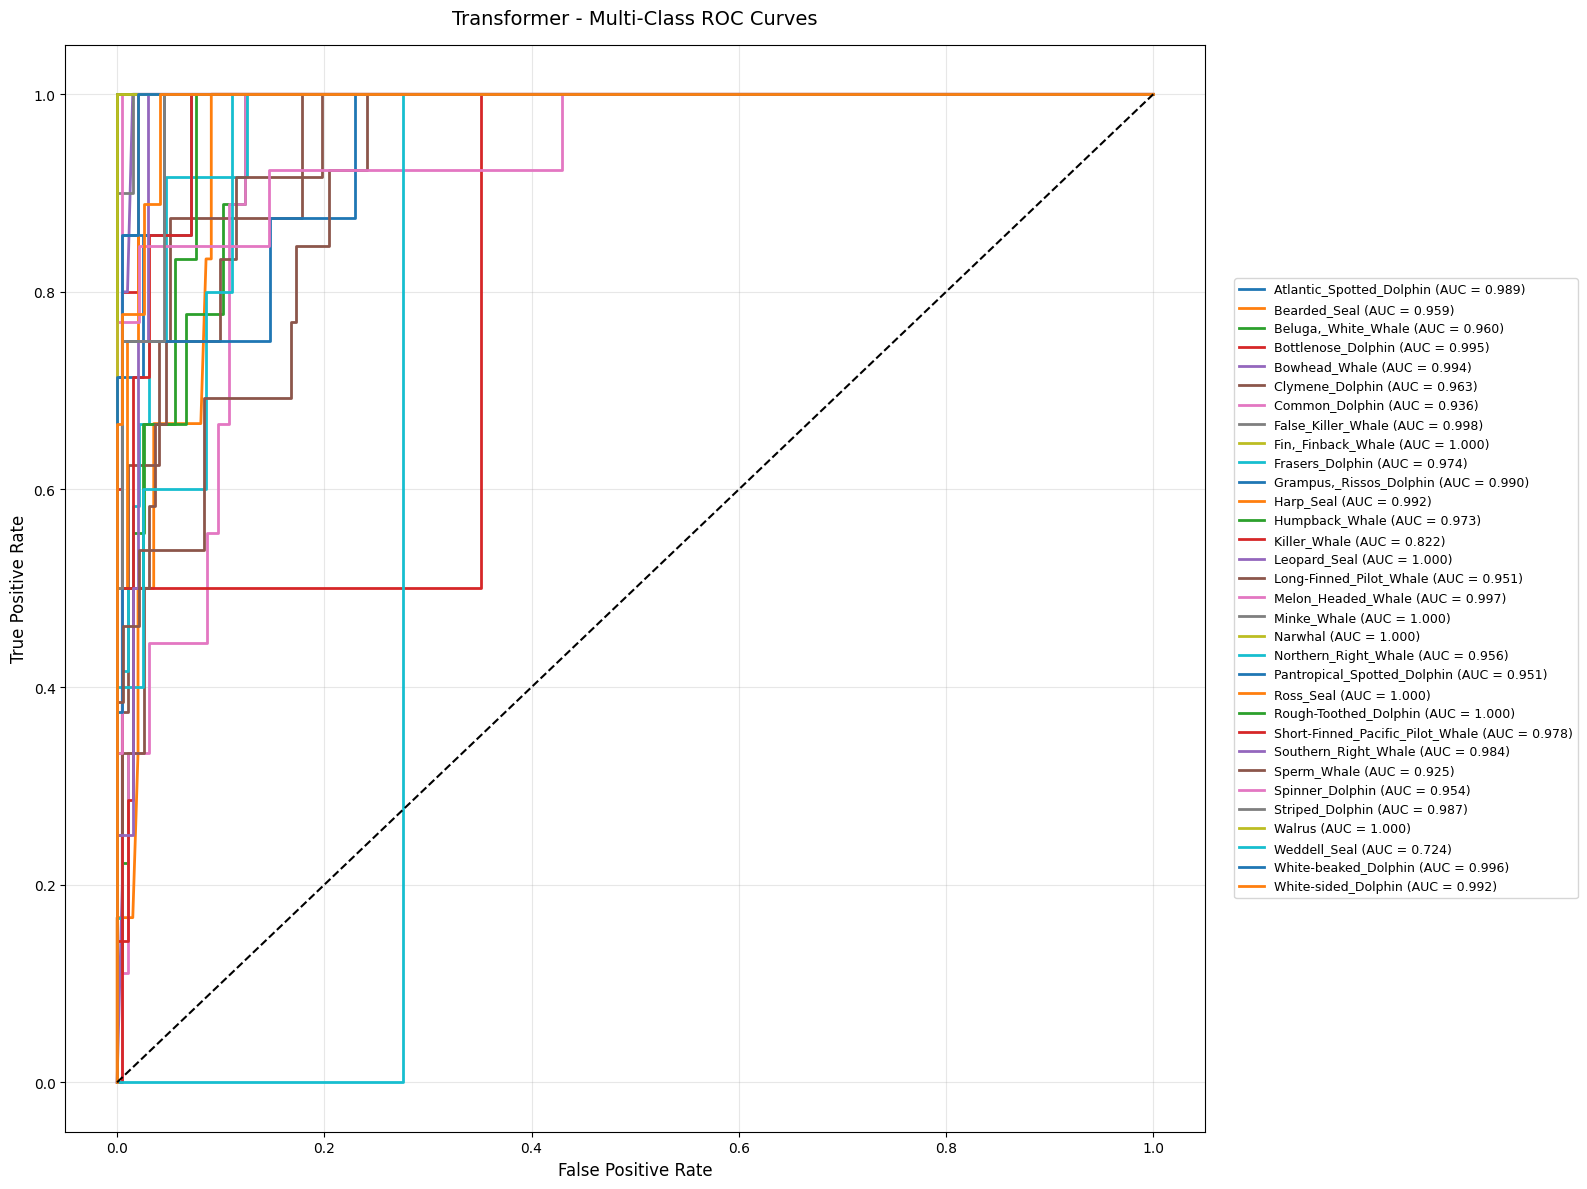

In [26]:
model_transformer = TransformerClassifier(
    input_size=spec_height,
    num_classes=num_classes
).to(device)

results['Transformer'] = train_and_evaluate(
    model_transformer, "Transformer",
    train_loader_spec,
    val_loader_spec,
    test_loader_spec,
    epochs=25
)

plot_accuracy_curves(results, "Transformer")
plot_multiclass_roc(results, "Transformer", num_classes)




=== Training RawAudioCNN ===
Epoch 1/25: Train Loss: 3.1441, Train Acc: 14.12% | Val Loss: 3.6263, Val Acc: 2.45%
Epoch 2/25: Train Loss: 2.4638, Train Acc: 32.03% | Val Loss: 3.0566, Val Acc: 10.78%
Epoch 3/25: Train Loss: 2.0199, Train Acc: 43.84% | Val Loss: 2.3082, Val Acc: 41.18%
Epoch 4/25: Train Loss: 1.7635, Train Acc: 49.00% | Val Loss: 2.0316, Val Acc: 45.59%
Epoch 5/25: Train Loss: 1.5512, Train Acc: 55.74% | Val Loss: 1.8277, Val Acc: 55.88%
Epoch 6/25: Train Loss: 1.4069, Train Acc: 59.11% | Val Loss: 1.7684, Val Acc: 56.37%
Epoch 7/25: Train Loss: 1.3396, Train Acc: 59.54% | Val Loss: 1.6600, Val Acc: 54.41%
Epoch 8/25: Train Loss: 1.1430, Train Acc: 69.86% | Val Loss: 1.9250, Val Acc: 42.16%
Epoch 9/25: Train Loss: 1.0757, Train Acc: 70.07% | Val Loss: 1.7008, Val Acc: 53.43%
Epoch 10/25: Train Loss: 0.9623, Train Acc: 72.39% | Val Loss: 1.5683, Val Acc: 64.71%
Epoch 11/25: Train Loss: 0.9164, Train Acc: 75.87% | Val Loss: 1.6735, Val Acc: 52.94%
Epoch 12/25: Train Loss

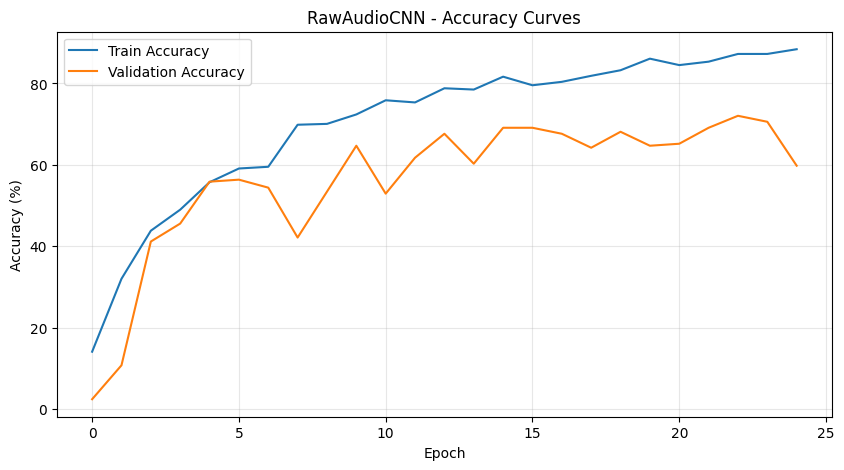

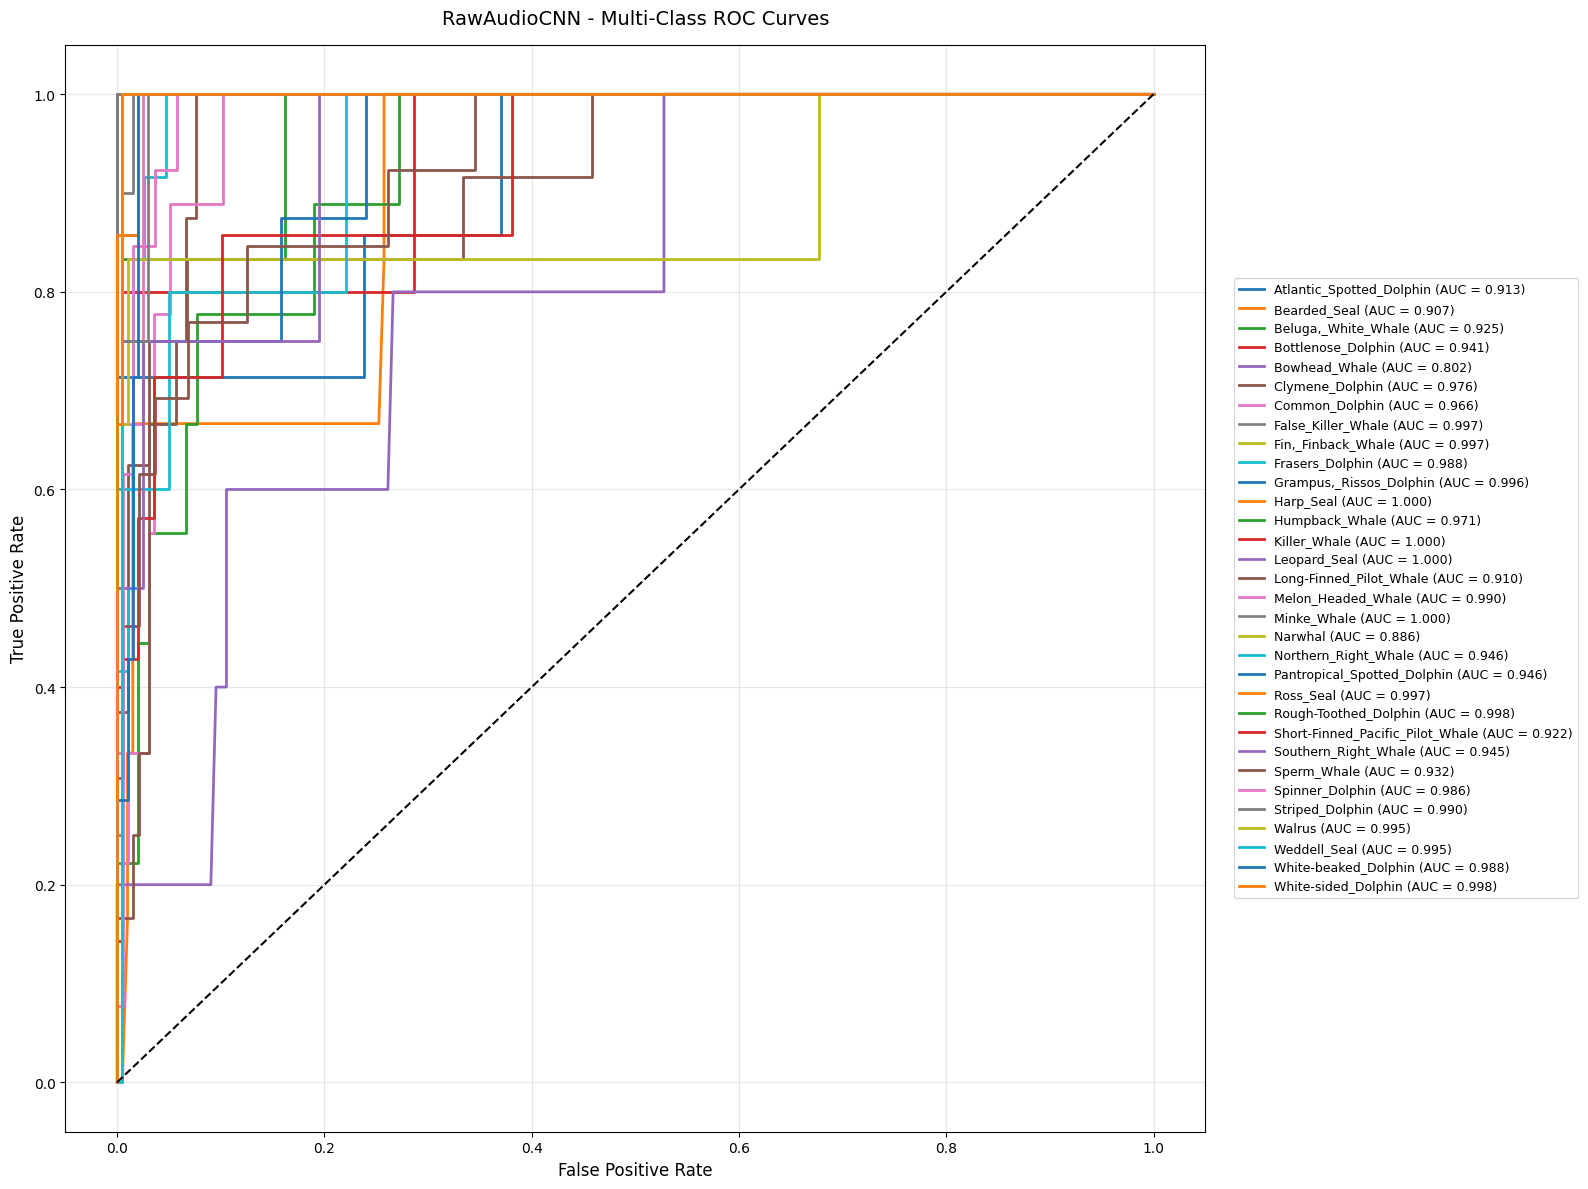

In [27]:
model_raw = RawAudioCNN(num_classes).to(device)

results['RawAudioCNN'] = train_and_evaluate(
    model_raw,
    "RawAudioCNN",
    train_loader_audio,
    val_loader_audio,
    test_loader_audio,
    25
)

plot_accuracy_curves(results, "RawAudioCNN")
plot_multiclass_roc(results, "RawAudioCNN", num_classes)

### Task 7: Constrastive Model


In [28]:
class ContrastiveModel(nn.Module):
    def __init__(self, base_cnn, embedding_dim=128, num_classes=num_classes):
        super().__init__()
        self.encoder = base_cnn.features
        self.projector = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, embedding_dim)
        )
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x, return_embedding=False):
        features = self.encoder(x)
        embedding = F.normalize(self.projector(features), dim=1)
        if return_embedding:
            return embedding
        return self.classifier(embedding)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        batch_size = features.shape[0]

        features = F.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)

        logits_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
        logits = similarity_matrix - logits_max.detach()

        exp_logits = torch.exp(logits)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        loss = -mean_log_prob_pos.mean()
        return loss


Phase 1: Contrastive Pretraining
Epoch 5/15 Contrastive Loss: 1.9272
Epoch 10/15 Contrastive Loss: 1.7097
Epoch 15/15 Contrastive Loss: 1.6445


Phase 2: Classifier Fine-Tuning

=== Training Contrastive ===
Epoch 1/15: Train Loss: 3.3460, Train Acc: 18.02% | Val Loss: 3.2712, Val Acc: 27.94%
Epoch 2/15: Train Loss: 3.1675, Train Acc: 35.72% | Val Loss: 3.1331, Val Acc: 26.47%
Epoch 3/15: Train Loss: 3.0448, Train Acc: 40.89% | Val Loss: 3.0295, Val Acc: 41.18%
Epoch 4/15: Train Loss: 2.9200, Train Acc: 46.36% | Val Loss: 2.9202, Val Acc: 40.69%
Epoch 5/15: Train Loss: 2.7973, Train Acc: 52.37% | Val Loss: 2.8108, Val Acc: 39.22%
Epoch 6/15: Train Loss: 2.6966, Train Acc: 51.53% | Val Loss: 2.7989, Val Acc: 42.65%
Epoch 7/15: Train Loss: 2.5832, Train Acc: 54.37% | Val Loss: 2.7553, Val Acc: 33.33%
Epoch 8/15: Train Loss: 2.4849, Train Acc: 56.38% | Val Loss: 2.5461, Val Acc: 45.10%
Epoch 9/15: Train Loss: 2.3945, Train Acc: 59.43% | Val Loss: 2.6227, Val Acc: 34.31%
Epoch 10/15: Train 

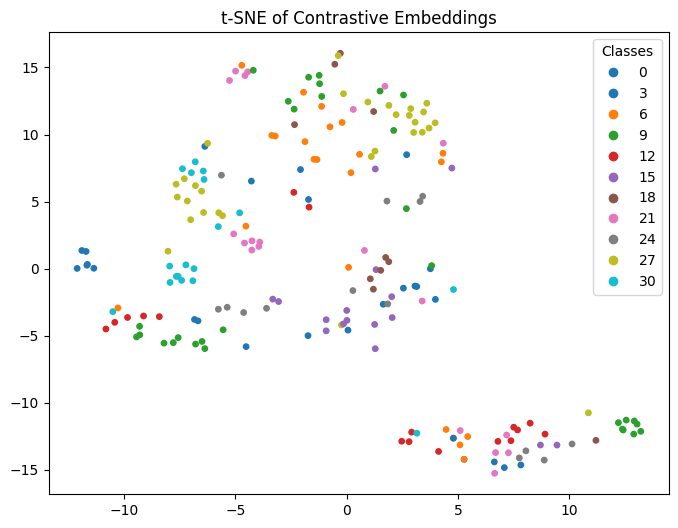

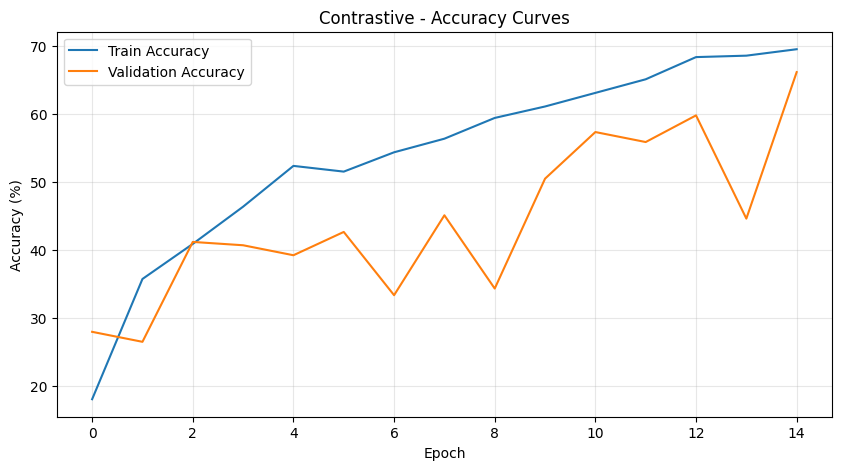

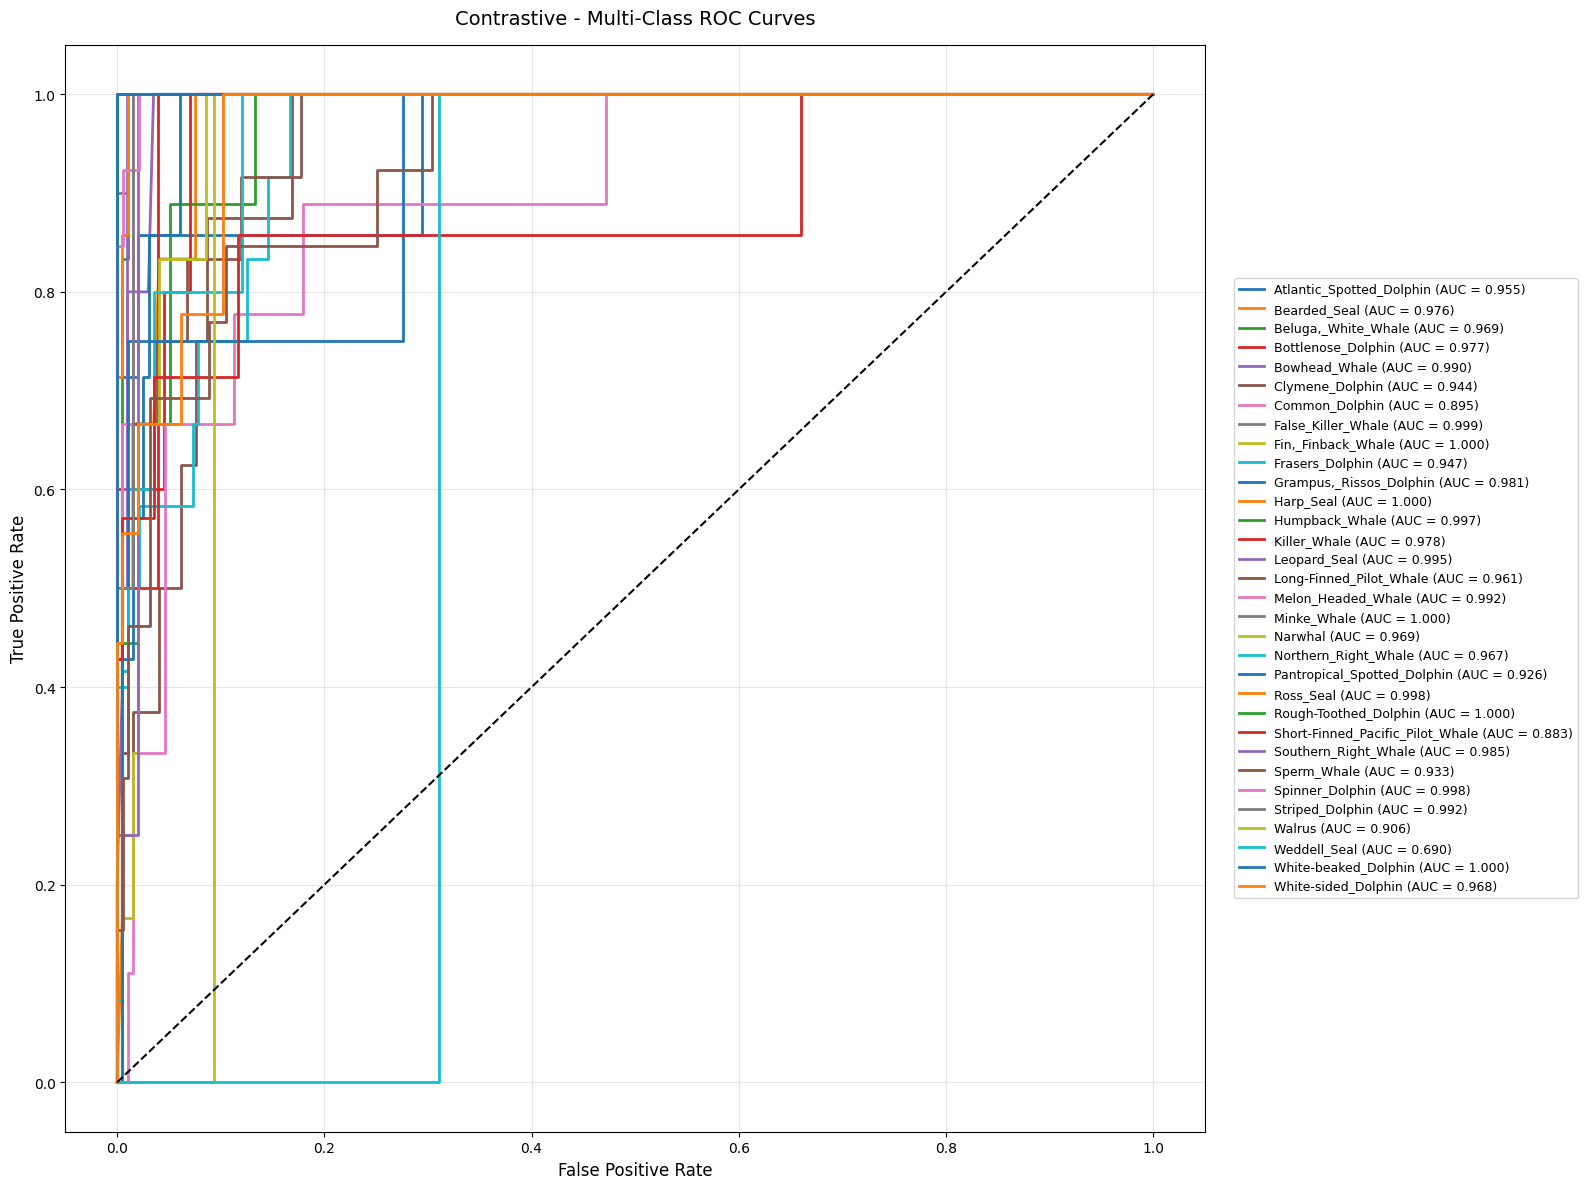

In [29]:
from sklearn.manifold import TSNE
def train_contrastive(model, train_loader, val_loader, epochs=15, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    con_loss_fn = SupConLoss()
    ce_loss_fn = nn.CrossEntropyLoss()

    device = next(model.parameters()).device

    # Phase 1: Contrastive pretraining
    print("Phase 1: Contrastive Pretraining")
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(inputs, return_embedding=True)
            loss = con_loss_fn(embeddings, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} Contrastive Loss: {total_loss/len(train_loader):.4f}")

    # Phase 2: Classification fine-tuning
    print("\n\nPhase 2: Classifier Fine-Tuning")
    return train_and_evaluate(model, "Contrastive", train_loader, val_loader, test_loader_spec, epochs=15)

# t-SNE Embedding Visualization
def visualize_embeddings(model, data_loader, num_samples=500):
    model.eval()
    embeddings_list = []
    labels_list = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            embeddings = model(inputs, return_embedding=True)
            embeddings_list.append(embeddings.cpu())
            labels_list.append(labels.cpu())
            if len(torch.cat(embeddings_list)) >= num_samples:
                break
    embeddings = torch.cat(embeddings_list)[:num_samples].numpy()
    labels = torch.cat(labels_list)[:num_samples].numpy()

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=15)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("t-SNE of Contrastive Embeddings")
    plt.show()

# Use your previously defined CNN backbone
base_cnn = CNN(num_classes).to(device)
contrastive_model = ContrastiveModel(base_cnn, embedding_dim=128, num_classes=num_classes).to(device)

results['Contrastive'] = train_contrastive(contrastive_model, train_loader_spec, val_loader_spec, epochs=15)

visualize_embeddings(contrastive_model, test_loader_spec)

plot_accuracy_curves(results, "Contrastive")
plot_multiclass_roc(results, "Contrastive", num_classes)


### VAE Audio Reconstruction

In [33]:
import librosa
import soundfile as sf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import umap


def spectrogram_to_waveform(mel_spec, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_iter=32, power=1.0):
    """
    Robust conversion: accepts either
      - dB-scaled mel-spectrogram (typical: negative..0)
      - sigmoid-style [0,1] outputs (from VAE decoder)
      - linear non-negative power mel (rare)
    Returns waveform (1D numpy float).
    """
    mel = np.array(mel_spec).astype(np.float32)

    # If batched, take first (the caller should loop for multiple)
    if mel.ndim == 3:
        mel = mel[0]

    # Safety: ensure finite
    mel = np.nan_to_num(mel, neginf=1e-8, posinf=1e8)

    # Heuristic detection:
    maxv = mel.max()
    minv = mel.min()

    if maxv <= 1.0:
        # Sigmoid output in [0,1] → map to [-40, 0] dB
        mel_db = mel * 40.0 - 40.0
        mel_power = librosa.db_to_power(mel_db)

    elif minv < 0 and maxv <= 200:
        # Already in dB scale
        mel_power = librosa.db_to_power(mel)

    else:
        # Already linear power
        mel_power = np.maximum(mel, 1e-8)

    # Griffin-Lim inversion via mel_to_audio
    y = librosa.feature.inverse.mel_to_audio(
        mel_power,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_iter=n_iter,
        power=power
    )

    return y


def save_wave(wave, path, sr=SR):
    """Write waveform to disk (16-bit float)"""
    sf.write(path, wave, sr)


def generate_vae_sample(vae, sr=SR, return_wave=False):
    vae.eval()

    if hasattr(vae, 'fc_mu'):
        latent_dim = vae.fc_mu.out_features
    else:
        latent_dim = 64

    z = torch.randn(1, latent_dim).to(device)

    with torch.no_grad():
        spec = vae.decode(z)

    spec_np = spec.cpu().numpy().squeeze()

    try:
        y = spectrogram_to_waveform(spec_np, sr=sr)
    except Exception as e:
        print("Waveform reconstruction failed:", e)
        y = None

    if return_wave:
        return spec_np, y

    return spec_np


def diffusion_spectrograms_to_wav(synthetic_array, out_dir='./diffusion_generated', sr=SR):
    os.makedirs(out_dir, exist_ok=True)

    arr = np.array(synthetic_array)

    if arr.ndim == 4:
        arr = arr.squeeze(1)

    paths = []

    for i in range(len(arr)):
        mel = arr[i]
        wave = spectrogram_to_waveform(mel, sr=sr)
        p = os.path.join(out_dir, f'diff_gen_{i}.wav')
        save_wave(wave, p, sr=sr)
        paths.append(p)

    return paths


### Task 8: Variational Autoencoder (VAE) Architecture and Training

In [34]:
class LightVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1),  # H/2 x W/2
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1), # H/4 x W/4
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # H/8 x W/8
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(64 * (spec_height//8) * (SPEC_LENGTH//8), latent_dim)
        self.fc_logvar = nn.Linear(64 * (spec_height//8) * (SPEC_LENGTH//8), latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * (spec_height//8) * (SPEC_LENGTH//8))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # H/4 x W/4
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),  # H/2 x W/2
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),   # H x W
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 64, spec_height//8, SPEC_LENGTH//8)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld, recon_loss, kld

def train_vae_and_augment(train_loader, X_train, y_train, latent_dim=64, epochs=30, beta=1.0):
    vae = LightVAE(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

    print("Training VAE...")
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = vae(inputs)
            loss, _, _ = vae_loss(recon, inputs, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

    # Generate synthetic samples (20% per class)
    vae.eval()
    synthetic_data = []
    synthetic_labels = []

    with torch.no_grad():
        for class_idx in range(num_classes):
            class_mask = y_train == class_idx
            class_samples = X_train[class_mask]
            class_count = len(class_samples)
            if class_count > 0:
                num_synthetic = max(1, int(0.2 * class_count))
                z = torch.randn(num_synthetic, latent_dim).to(device)
                synthetic = vae.decode(z).cpu().numpy()
                synthetic_data.extend(synthetic)
                synthetic_labels.extend([class_idx]*num_synthetic)

    # Combine with original data
    X_train_aug = np.concatenate([X_train, np.array(synthetic_data).squeeze()], axis=0)
    y_train_aug = np.concatenate([y_train, synthetic_labels], axis=0)

    print(f"Original samples: {len(X_train)}, Synthetic: {len(synthetic_data)}, Total Augmented: {len(X_train_aug)}")

    # Create augmented DataLoader
    train_dataset_aug = SpectrogramDataset(X_train_aug, y_train_aug)
    train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)

    return train_loader_aug, vae

def visualize_vae_samples(vae, original_samples, num_samples=5):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, vae.fc_mu.out_features).to(device)
        generated = vae.decode(z).cpu().numpy()

    fig, axes = plt.subplots(2, num_samples, figsize=(15,6))
    for i in range(num_samples):
        axes[0, i].imshow(original_samples[i].squeeze(), aspect='auto', cmap='viridis')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

        axes[1, i].imshow(generated[i].squeeze(), aspect='auto', cmap='viridis')
        axes[1, i].set_title(f'Generated {i+1}')
        axes[1, i].axis('off')
    plt.suptitle("VAE: Original vs Generated Spectrograms")
    plt.show()

def visualize_vae_latent_space(vae, data_loader, n_samples=1000, method='tsne'):
    """
    vae: trained VAE instance with .encode() or forward that returns (recon, mu, logvar)
    data_loader: DataLoader (spectrograms)
    method: 'tsne' or 'umap'
    """
    vae.eval()
    zs, ys = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            # use encode if available
            if hasattr(vae, 'encode'):
                mu, logvar = vae.encode(inputs)
            else:
                _, mu, logvar = vae(inputs)
            z = mu.cpu().numpy()
            zs.append(z)
            ys.append(labels.cpu().numpy())
            if len(np.concatenate(zs, axis=0)) >= n_samples:
                break

    zs = np.concatenate(zs, axis=0)[:n_samples]
    ys = np.concatenate(ys, axis=0)[:n_samples]

    if method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
        emb2 = reducer.fit_transform(zs)
    else:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        emb2 = tsne.fit_transform(zs)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(emb2[:, 0], emb2[:, 1], c=ys, cmap='tab20', s=8, alpha=0.8)
    plt.legend(*scatter.legend_elements(num=10), title="Classes", bbox_to_anchor=(1.04,1), loc='upper left')
    plt.title(f'VAE Latent Space ({method.upper()})')
    plt.tight_layout()
    plt.show()


Training VAE...
Epoch 10/30, Loss: 490824078.9333
Epoch 20/30, Loss: 490821793.0667
Epoch 30/30, Loss: 490821239.4667
Original samples: 949, Synthetic: 178, Total Augmented: 1127


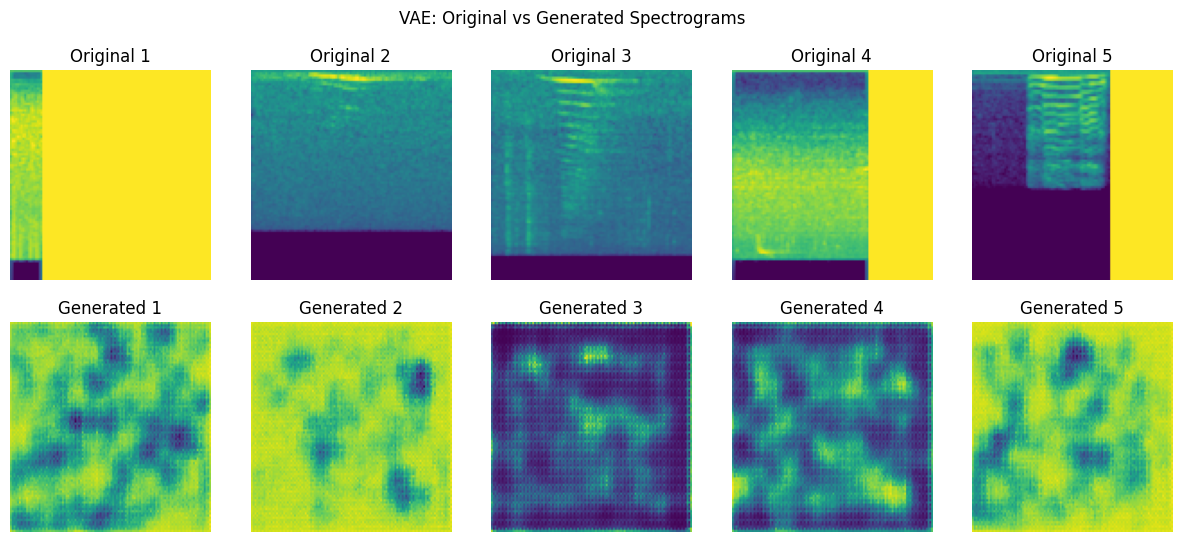

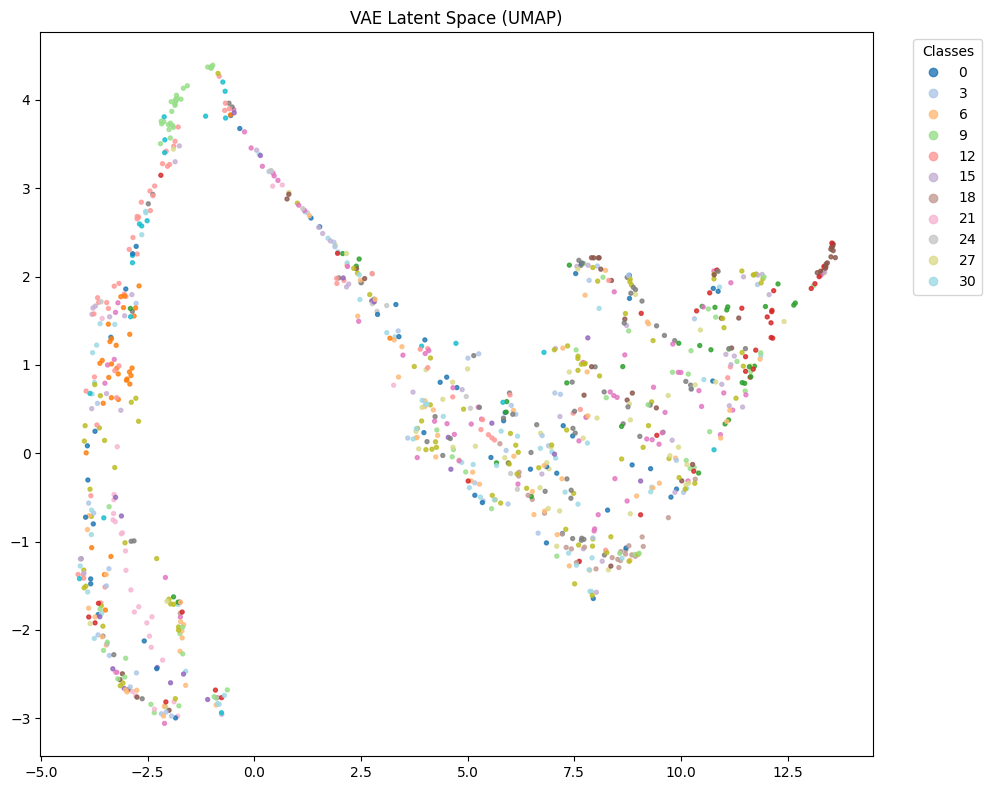

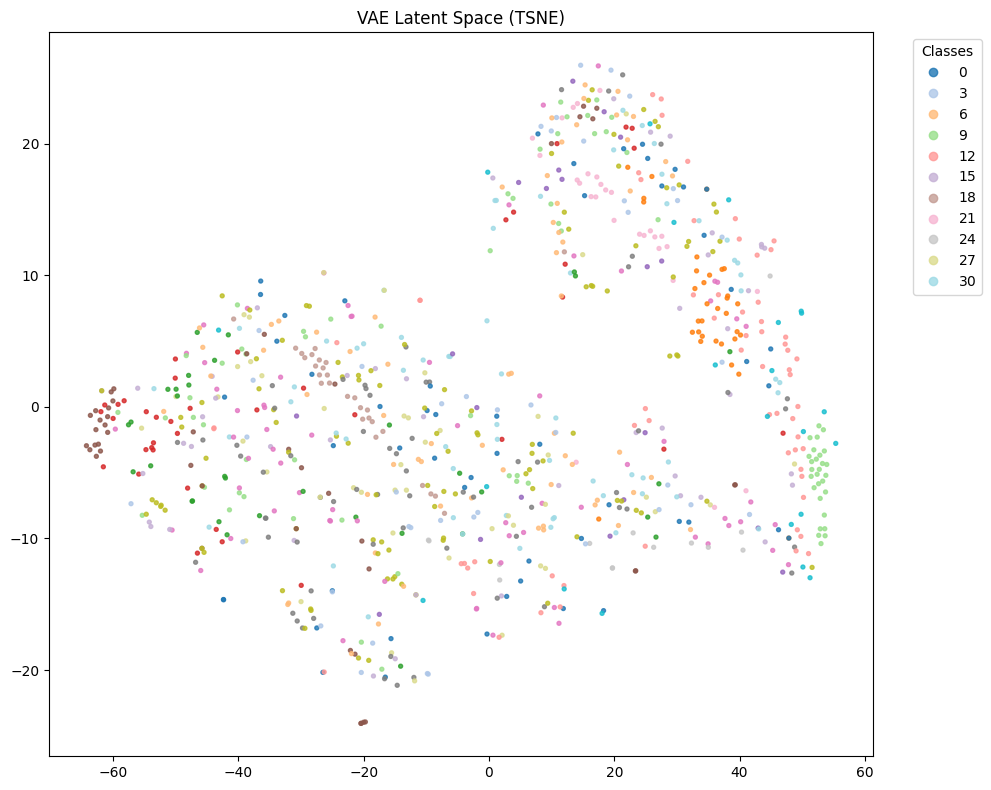

Retraining best model: CNN

=== Training CNN_VAE_aug ===
Epoch 1/30: Train Loss: 3.5666, Train Acc: 15.53% | Val Loss: 2.7437, Val Acc: 30.88%
Epoch 2/30: Train Loss: 2.5462, Train Acc: 32.03% | Val Loss: 2.6022, Val Acc: 40.69%
Epoch 3/30: Train Loss: 2.0493, Train Acc: 43.39% | Val Loss: 1.7959, Val Acc: 45.10%
Epoch 4/30: Train Loss: 1.7637, Train Acc: 48.80% | Val Loss: 1.3829, Val Acc: 59.31%
Epoch 5/30: Train Loss: 1.5418, Train Acc: 55.81% | Val Loss: 1.3794, Val Acc: 62.25%
Epoch 6/30: Train Loss: 1.4149, Train Acc: 58.74% | Val Loss: 1.3214, Val Acc: 59.80%
Epoch 7/30: Train Loss: 1.2084, Train Acc: 64.15% | Val Loss: 1.2101, Val Acc: 64.71%
Epoch 8/30: Train Loss: 1.0905, Train Acc: 67.44% | Val Loss: 1.5744, Val Acc: 57.84%
Epoch 9/30: Train Loss: 1.0455, Train Acc: 69.12% | Val Loss: 2.3658, Val Acc: 51.96%
Epoch 10/30: Train Loss: 0.9394, Train Acc: 71.96% | Val Loss: 1.4444, Val Acc: 65.69%
Epoch 11/30: Train Loss: 0.8608, Train Acc: 75.69% | Val Loss: 1.2814, Val Acc: 70

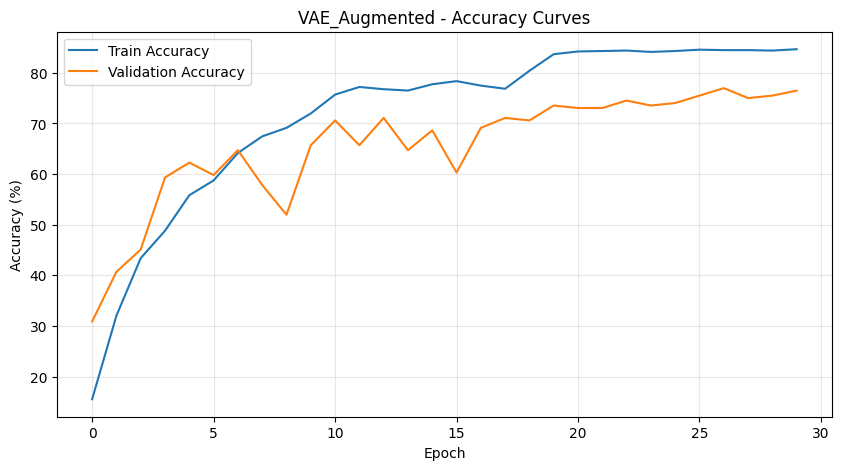

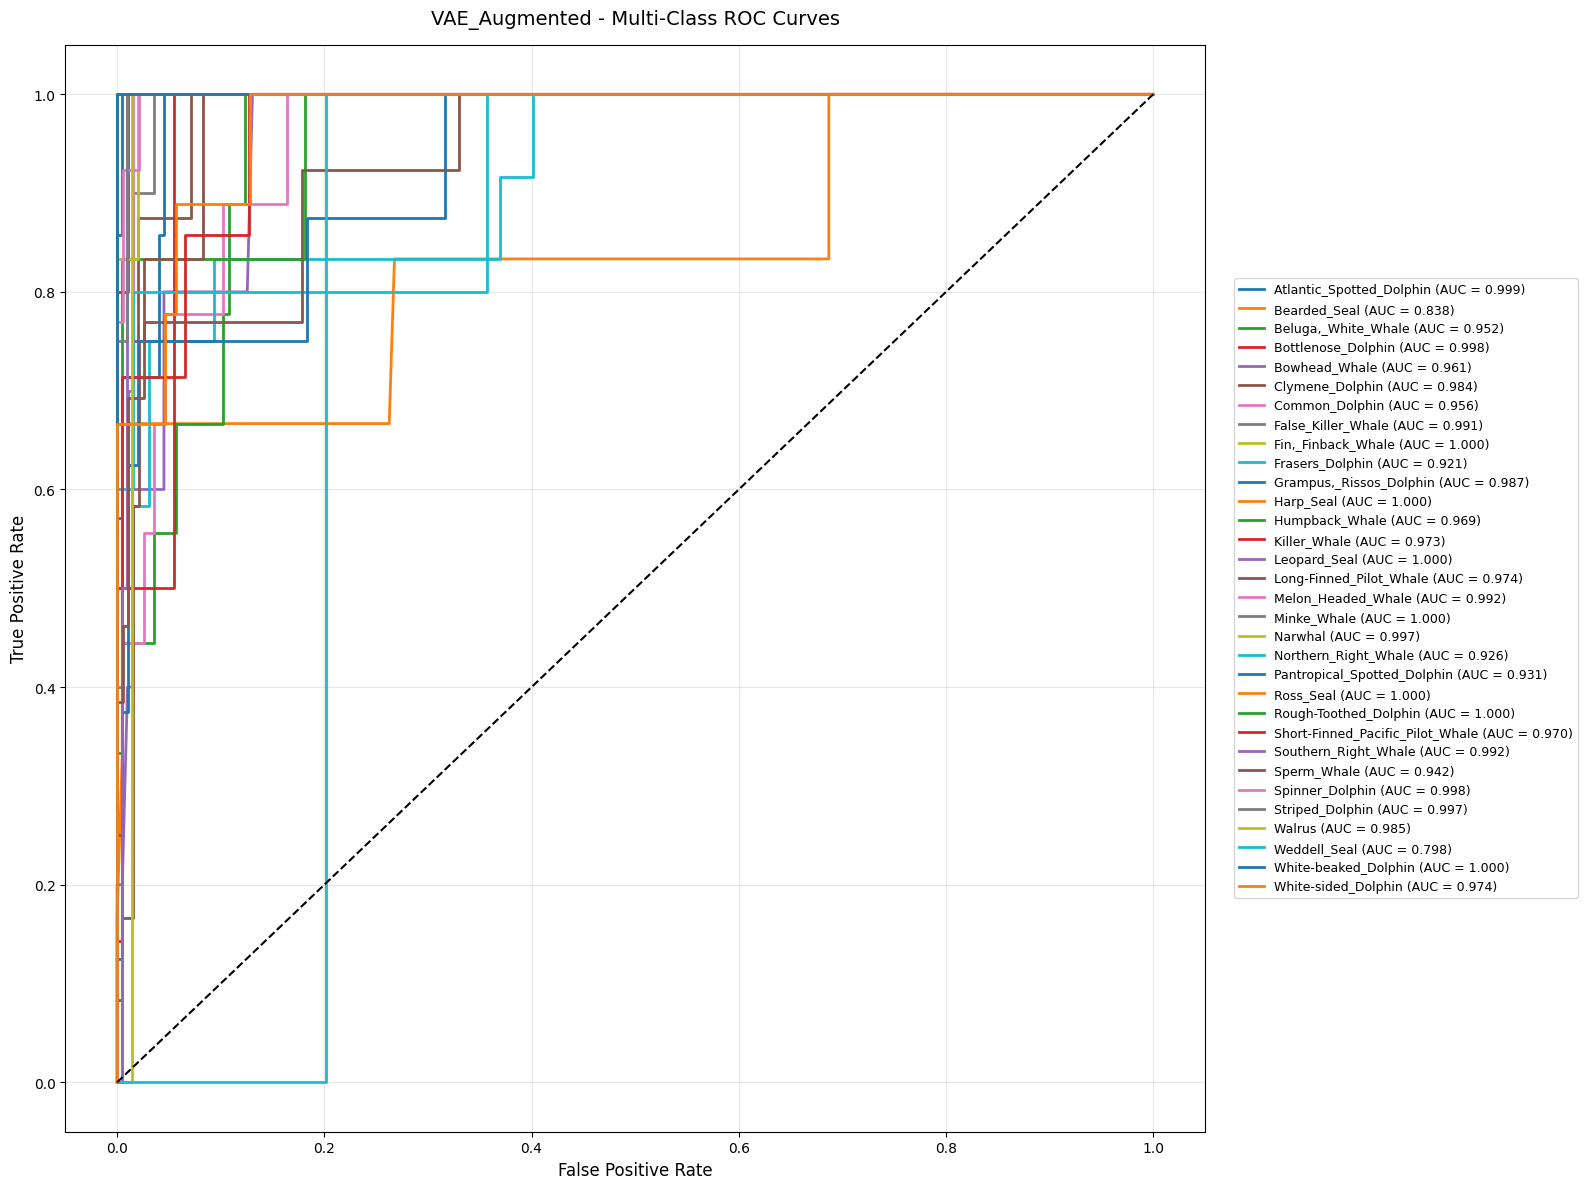

In [35]:
# Execute VAE Augmentation
train_loader_aug, vae_model = train_vae_and_augment(train_loader_spec, X_train_spec, y_train, latent_dim=64, epochs=30)

visualize_vae_samples(vae_model, X_train_spec[:5], num_samples=5)

visualize_vae_latent_space(
    vae_model,
    train_loader_spec,
    n_samples=1000,
    method='umap'
)
visualize_vae_latent_space(
    vae_model,
    train_loader_spec,
    n_samples=1000,
    method='tsne'
)

# Retrain Best Model with Augmented Data
best_model_name = max([(k, v) for k, v in results.items() if k != 'Contrastive'],
                      key=lambda x: x[1]['test_accuracy'])[0]
print(f"Retraining best model: {best_model_name}")

if best_model_name == 'DNN':
    best_model = DNN(dnn_input_size, num_classes).to(device)
elif best_model_name == 'CNN':
    best_model = CNN(num_classes).to(device)
elif best_model_name == 'RNN':
    best_model = RNN(spec_height, 128, 2, num_classes).to(device)
elif best_model_name == 'LSTM':
    best_model = LSTM(spec_height, 128, 2, num_classes).to(device)
elif best_model_name == 'Transformer':
    best_model = TransformerClassifier(spec_height, num_classes).to(device)
else:
    best_model = CNN(num_classes).to(device)

results['VAE_Augmented'] = train_and_evaluate(
    best_model,
    model_name=f"{best_model_name}_VAE_aug",
    train_loader=train_loader_aug,
    val_loader=val_loader_spec,
    test_loader=test_loader_spec,
    epochs=30
)

test_acc = results['VAE_Augmented']['test_accuracy']
print(f"TASK 8 - VAE Augmented {best_model_name} Test Accuracy: {test_acc:.2f}%")

plot_accuracy_curves(results, 'VAE_Augmented')
plot_multiclass_roc(results, 'VAE_Augmented', num_classes)

In [36]:
print("\n=== VAE SAMPLE GENERATION & AUDIO RECONSTRUCTION ===")

vae_audio_dir = "./vae_audio_outputs"
vae_audio_dir_drive = "/content/drive/MyDrive/wmms_outputs/vae_audio_outputs"
os.makedirs(vae_audio_dir, exist_ok=True)
os.makedirs(vae_audio_dir_drive, exist_ok=True)

vae_specs = []
vae_wav_paths_drive = []
recon_metrics = []

for i in range(5):
    spec_np, wave = generate_vae_sample(vae_model, return_wave=True)
    if wave is None:
        print(f"[VAE] sample {i} reconstruction failed.")
        continue

    # Save local and to Drive
    wav_local = os.path.join(vae_audio_dir, f"vae_sample_{i}.wav")
    save_wave(wave, wav_local, sr=SR)
    wav_drive = os.path.join(vae_audio_dir_drive, f"vae_sample_{i}.wav")
    save_wave(wave, wav_drive, sr=SR)

    vae_specs.append(spec_np)
    vae_wav_paths_drive.append(wav_drive)
    print(f"[VAE] Saved: {wav_drive}")

    # Simple spec-level MSE against nearest original spectrogram (rough indicator)
    flat_gen = spec_np.flatten()
    all_flat = X_train_spec.reshape(X_train_spec.shape[0], -1)
    dists = np.linalg.norm(all_flat - flat_gen, axis=1)
    nearest_idx = np.argmin(dists)
    nearest_spec = X_train_spec[nearest_idx]
    mse_spec = float(np.mean((nearest_spec - spec_np)**2))

    # Waveform SNR (rough): use nearest original audio if available
    try:
        orig_wave = pad_or_truncate_audio(raw_audios[nearest_idx], target_length=AUDIO_LENGTH)
        # Trim/pad to generated length
        L = min(len(orig_wave), len(wave))
        mse_wave = float(np.mean((orig_wave[:L] - wave[:L])**2))
        snr = 10 * np.log10((np.var(orig_wave[:L]) + 1e-9) / (mse_wave + 1e-9))
    except Exception:
        snr = float('nan')

    recon_metrics.append({'sample': i, 'nearest_idx': int(nearest_idx),
                          'mse_spec': mse_spec, 'snr_wave_db': float(snr)})

if len(vae_specs) > 0:
    allv = np.concatenate([s.flatten() for s in vae_specs])
    print("VAE generated spectrogram range:", float(allv.min()), float(allv.max()))

if len(recon_metrics) > 0:
    display(pd.DataFrame(recon_metrics))


=== VAE SAMPLE GENERATION & AUDIO RECONSTRUCTION ===
[VAE] Saved: /content/drive/MyDrive/wmms_outputs/vae_audio_outputs/vae_sample_0.wav
[VAE] Saved: /content/drive/MyDrive/wmms_outputs/vae_audio_outputs/vae_sample_1.wav
[VAE] Saved: /content/drive/MyDrive/wmms_outputs/vae_audio_outputs/vae_sample_2.wav
[VAE] Saved: /content/drive/MyDrive/wmms_outputs/vae_audio_outputs/vae_sample_3.wav
[VAE] Saved: /content/drive/MyDrive/wmms_outputs/vae_audio_outputs/vae_sample_4.wav
VAE generated spectrogram range: 1.782523759175092e-05 0.45044952630996704


sample  nearest_idx  mse_spec  snr_wave_db
0       0          159  9.720435    -0.053924
1       1          159  9.552691    -0.012732
2       2          159  9.472461    -0.010148
3       3          159  9.756749    -0.082857
4       4          159  9.800679    -0.099282

### Task 9: Diffusion Model Architecture and Training

In [37]:
class ConditionalDiffusion(nn.Module):
    def __init__(self, num_classes, timesteps=500, device='cpu'):
        super(ConditionalDiffusion, self).__init__()
        self.timesteps = timesteps
        self.device = device

        # Linear noise schedule on the correct device
        self.betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        # Class embedding
        self.class_embed = nn.Embedding(num_classes, 128)
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )

        # Encoder
        self.enc1 = nn.Conv2d(1, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1, stride=2)

        # Middle with conditioning
        self.mid_conv = nn.Conv2d(256, 256, 3, padding=1)
        self.mid_time = nn.Conv2d(128, 256, 1)
        self.mid_class = nn.Conv2d(128, 256, 1)

        # Decoder
        self.dec3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.dec1 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t, class_labels):
        # Time and class embeddings
        t_emb = self.time_embed(t.view(-1, 1).float() / self.timesteps)
        t_emb = t_emb.view(t_emb.size(0), -1, 1, 1)

        class_emb = self.class_embed(class_labels)
        class_emb = class_emb.view(class_emb.size(0), -1, 1, 1)

        # Encoder
        h1 = F.relu(self.enc1(x))
        h2 = F.relu(self.enc2(h1))
        h3 = F.relu(self.enc3(h2))

        # Middle with conditioning
        h = F.relu(self.mid_conv(h3))
        h = h + self.mid_time(t_emb) + self.mid_class(class_emb)

        # Decoder
        h = F.relu(self.dec3(h))
        h = F.relu(self.dec2(h))
        h = self.dec1(h)

        return h

def diffusion_loss(model, x_0, class_labels, device):
    """Compute diffusion model loss"""
    batch_size = x_0.shape[0]

    # Sample random timesteps on the same device as model
    t = torch.randint(0, model.timesteps, (batch_size,), device=device)

    # Sample noise
    epsilon = torch.randn_like(x_0)

    # Ensure alpha_bars is on same device
    alpha_bars = model.alpha_bars.to(device)
    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)

    # Create noisy sample
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * epsilon

    # Predict noise
    epsilon_theta = model(x_t, t, class_labels)

    # MSE loss
    return F.mse_loss(epsilon_theta, epsilon)

def train_diffusion_model():
    """Train conditional diffusion model"""
    diffusion_model = ConditionalDiffusion(num_classes).to(device)
    optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=0.0002)

    print("Training Conditional Diffusion Model...")
    diffusion_model.train()
    diffusion_losses = []

    for epoch in range(100):  # More epochs for diffusion
        total_loss = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader_spec):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            loss = diffusion_loss(diffusion_model, inputs, labels, device)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Memory management
            if batch_idx % 50 == 0:
                gc.collect()

        diffusion_losses.append(total_loss / len(train_loader_spec))

        if (epoch + 1) % 20 == 0:
            print(f'Diffusion Epoch {epoch+1}/100, Loss: {diffusion_losses[-1]:.4f}')

    return diffusion_model, diffusion_losses

def generate_diffusion_samples(model, class_label, num_samples, device, steps=100):
    """Generate samples using DDPM sampling"""
    model.eval()
    with torch.no_grad():
        # Start from random noise
        x = torch.randn(num_samples, 1, N_MELS, SPEC_LENGTH, device=device)

        # Class labels for conditioning
        class_labels = torch.full((num_samples,), class_label, device=device, dtype=torch.long)

        # Reverse process (sampling)
        for t in range(model.timesteps-1, -1, -1):
            # Only sample some steps for efficiency (striding)
            if t % (model.timesteps // steps) != 0 and t != 0:
                continue

            t_batch = torch.full((num_samples,), t, device=device)

            # Predict noise
            epsilon_theta = model(x, t_batch, class_labels)

            # Get alpha parameters
            alpha_t = model.alphas[t].to(device)
            alpha_bar_t = model.alpha_bars[t].to(device)
            beta_t = model.betas[t].to(device)

            if t > 0:
                z = torch.randn_like(x)
            else:
                z = 0

            # DDPM sampling step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * epsilon_theta
            ) + torch.sqrt(beta_t) * z

    return x.cpu().numpy()

def diffusion_data_augmentation(diffusion_model):
    """Generate synthetic samples using diffusion model"""
    print("Generating diffusion-based synthetic samples...")

    synthetic_data = []
    synthetic_labels = []

    for class_idx in range(num_classes):
        class_count = np.sum(y_train == class_idx)
        num_synthetic = max(1, int(0.2 * class_count))

        print(f"Generating {num_synthetic} samples for class {class_idx} ({le.classes_[class_idx]})")

        # Generate class-conditioned samples
        synthetic = generate_diffusion_samples(
            diffusion_model, class_idx, num_synthetic, device, steps=50
        )

        synthetic_data.extend(synthetic)
        synthetic_labels.extend([class_idx] * num_synthetic)

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Convert list to NumPy array and remove extra channel dimension
    synthetic_data_array = np.array(synthetic_data)  # shape: [num_synthetic_total, 1, N_MELS, SPEC_LENGTH]
    synthetic_data_array = synthetic_data_array.squeeze(1)  # shape: [num_synthetic_total, N_MELS, SPEC_LENGTH]

    X_train_diffusion_aug = np.concatenate([X_train_spec, synthetic_data_array], axis=0)
    y_train_diffusion_aug = np.concatenate([y_train, synthetic_labels], axis=0)

    print(f"Original training samples: {len(X_train_spec)}")
    print(f"Diffusion synthetic samples: {len(synthetic_data_array)}")
    print(f"Diffusion augmented training samples: {len(X_train_diffusion_aug)}")
    print(f"Augmentation ratio: {len(synthetic_data_array)/len(X_train_spec)*100:.1f}%")

    # Create augmented dataset
    train_dataset_diffusion_aug = SpectrogramDataset(X_train_diffusion_aug, y_train_diffusion_aug)
    train_loader_diffusion_aug = DataLoader(train_dataset_diffusion_aug, batch_size=BATCH_SIZE, shuffle=True)

    return train_loader_diffusion_aug, synthetic_data_array


In [38]:

# Execute diffusion model training and augmentation
print("Starting Diffusion Model Training...")
diffusion_model, diffusion_losses = train_diffusion_model()


Starting Diffusion Model Training...
Training Conditional Diffusion Model...
Diffusion Epoch 20/100, Loss: 0.3983
Diffusion Epoch 40/100, Loss: 0.3619
Diffusion Epoch 60/100, Loss: 0.3550
Diffusion Epoch 80/100, Loss: 0.3317
Diffusion Epoch 100/100, Loss: 0.3584


Starting Diffusion-based Data Augmentation...
Generating diffusion-based synthetic samples...
Generating 6 samples for class 0 (Atlantic_Spotted_Dolphin)
Generating 4 samples for class 1 (Bearded_Seal)
Generating 5 samples for class 2 (Beluga,_White_Whale)
Generating 2 samples for class 3 (Bottlenose_Dolphin)
Generating 6 samples for class 4 (Bowhead_Whale)
Generating 7 samples for class 5 (Clymene_Dolphin)
Generating 5 samples for class 6 (Common_Dolphin)
Generating 6 samples for class 7 (False_Killer_Whale)
Generating 5 samples for class 8 (Fin,_Finback_Whale)
Generating 9 samples for class 9 (Frasers_Dolphin)
Generating 7 samples for class 10 (Grampus,_Rissos_Dolphin)
Generating 5 samples for class 11 (Harp_Seal)
Generating 7 samples for class 12 (Humpback_Whale)
Generating 4 samples for class 13 (Killer_Whale)
Generating 1 samples for class 14 (Leopard_Seal)
Generating 7 samples for class 15 (Long-Finned_Pilot_Whale)
Generating 7 samples for class 16 (Melon_Headed_Whale)
Generating

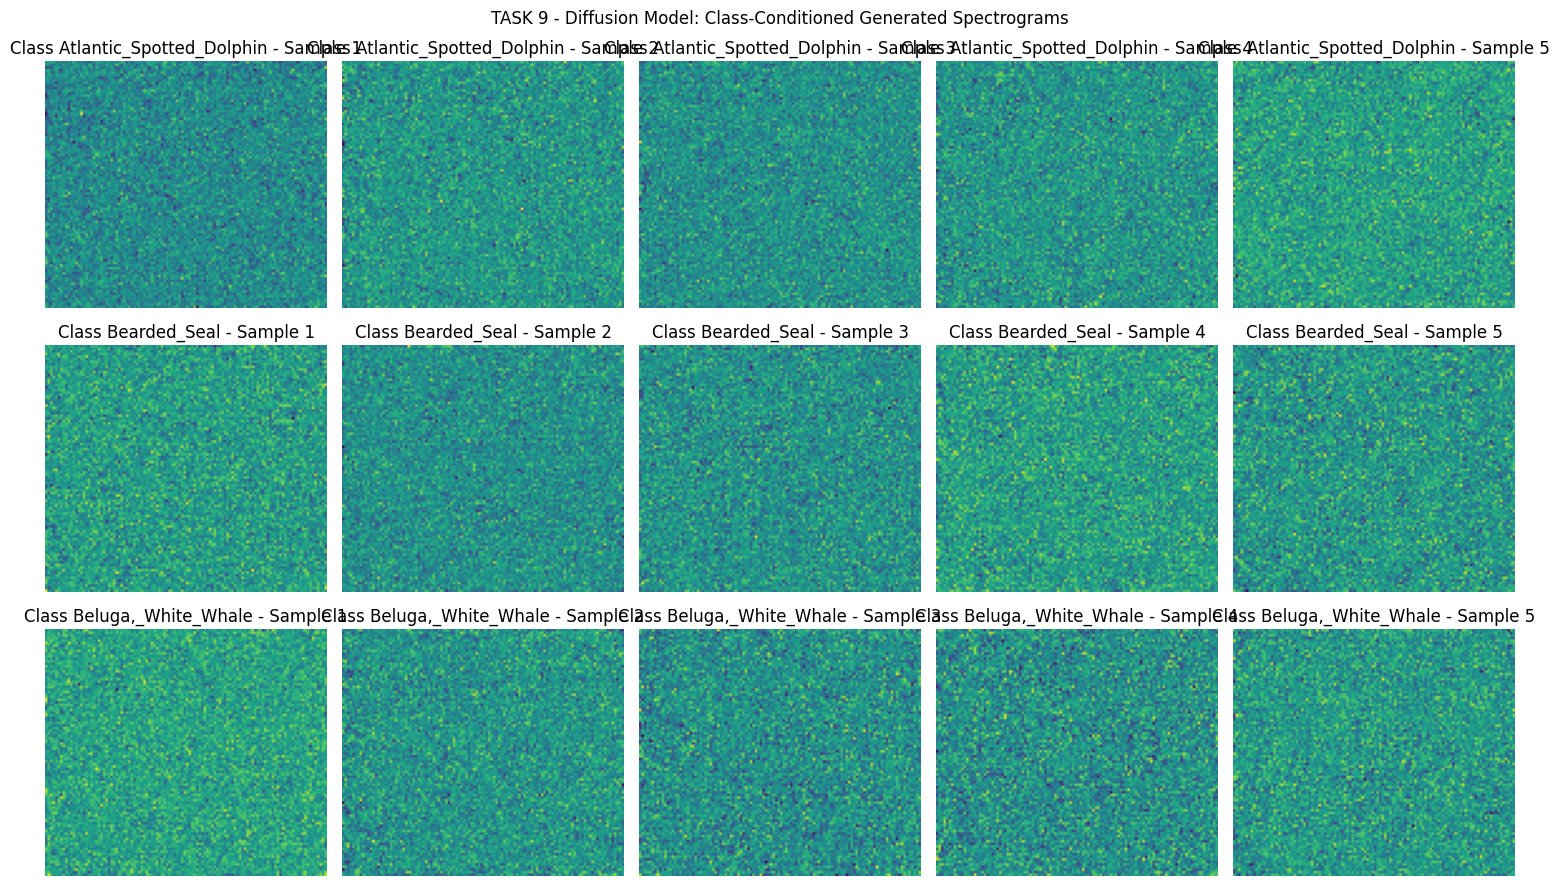

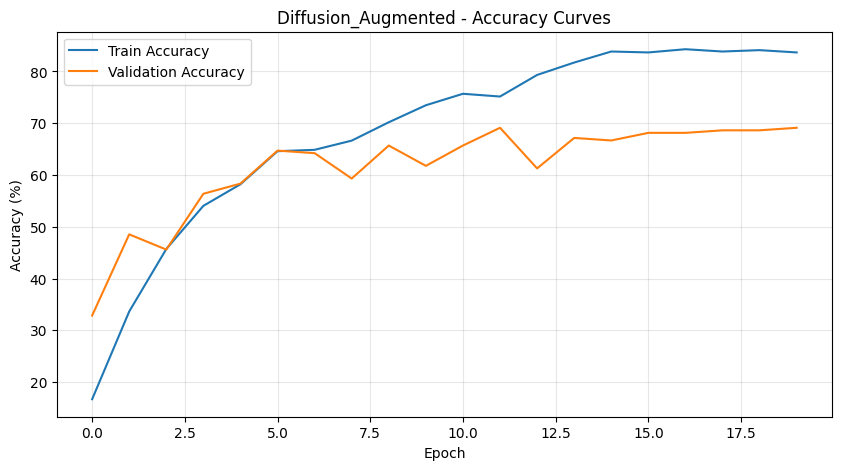

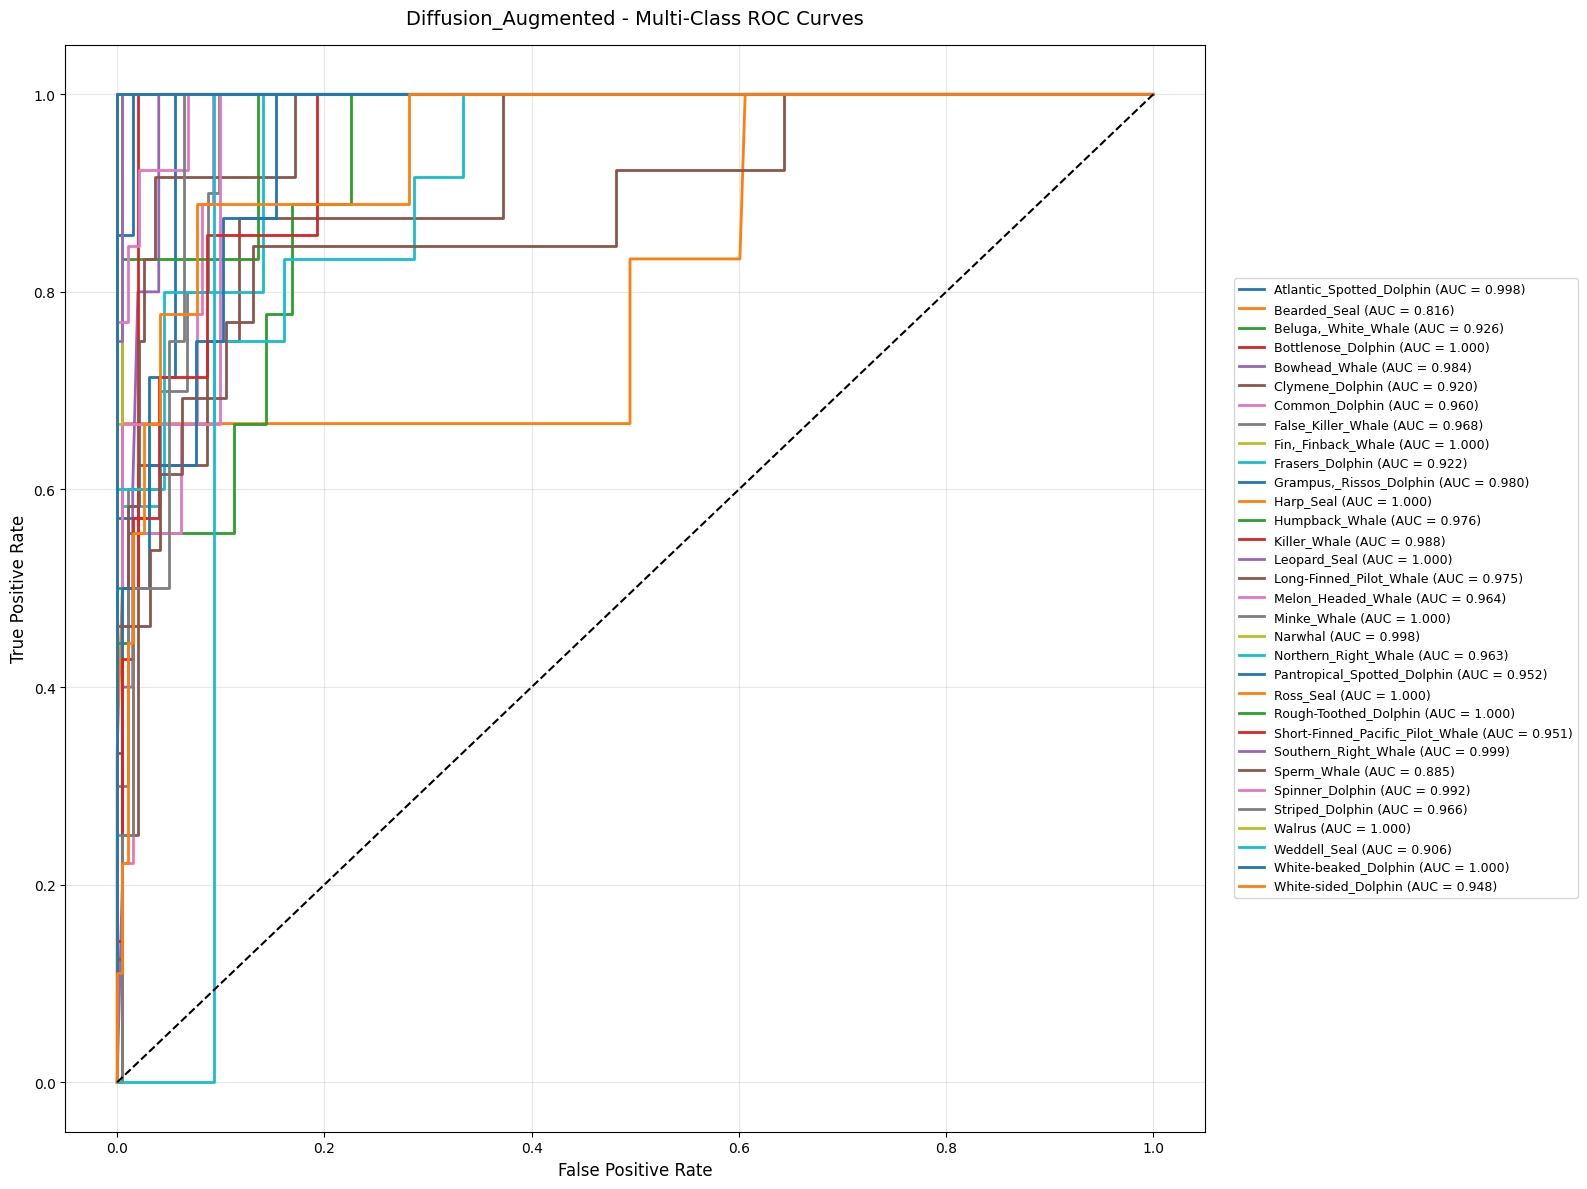

In [39]:

print("Starting Diffusion-based Data Augmentation...")
train_loader_diffusion_aug, diffusion_samples = diffusion_data_augmentation(diffusion_model)

# Retrain best model with diffusion-augmented data
print("\nRetraining best model with diffusion-augmented data...")
best_model_name = max([(k, v) for k, v in results.items() if k not in ['Contrastive', 'VAE_Augmented']],
                     key=lambda x: x[1]['test_accuracy'])[0]
print(f"Best model for diffusion augmentation: {best_model_name}")

# Reinitialize best model
if best_model_name == 'DNN':
    best_model_diffusion = DNN(dnn_input_size, num_classes).to(device)
elif best_model_name == 'CNN':
    best_model_diffusion = CNN(num_classes).to(device)
elif best_model_name == 'RNN':
    best_model_diffusion = RNN(spec_height, 128, 2, num_classes).to(device)
elif best_model_name == 'LSTM':
    best_model_diffusion = LSTM(spec_height, 128, 2, num_classes).to(device)
elif best_model_name == 'Transformer':
    best_model_diffusion = TransformerClassifier(spec_height, num_classes).to(device)
else:
    best_model_diffusion = CNN(num_classes).to(device)

results['Diffusion_Augmented'] = train_and_evaluate(
    best_model_diffusion,
    model_name=f"{best_model_name}_diffusion_aug",
    train_loader=train_loader_diffusion_aug,
    val_loader=val_loader_spec,
    test_loader=test_loader_spec,
    epochs=30
)

print(f"TASK 9 - Diffusion Augmented {best_model_name} Test Accuracy: "
      f"{results['Diffusion_Augmented']['test_accuracy']:.2f}%")


# Visualize diffusion generated samples
def visualize_diffusion_generations(diffusion_model, num_samples=5):
    diffusion_model.eval()

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))

    for class_idx in range(3):  # Show first 3 classes
        # Generate samples for this class
        generated = generate_diffusion_samples(
            diffusion_model, class_idx, num_samples, device, steps=50
        )

        for i in range(num_samples):
            axes[class_idx, i].imshow(generated[i].squeeze(), aspect='auto', cmap='viridis')
            axes[class_idx, i].set_title(f'Class {le.classes_[class_idx]} - Sample {i+1}')
            axes[class_idx, i].axis('off')

    plt.suptitle('TASK 9 - Diffusion Model: Class-Conditioned Generated Spectrograms')
    plt.tight_layout()
    plt.show()

# Show generated samples from diffusion model
print("Visualizing diffusion-generated samples...")
visualize_diffusion_generations(diffusion_model)


plot_accuracy_curves(results, 'Diffusion_Augmented')
plot_multiclass_roc(results, 'Diffusion_Augmented', num_classes)



In [40]:
print("\n=== DIFFUSION WAV EXPORT ===")

diffusion_wav_dir = "./diffusion_audio_outputs"
diffusion_wav_dir_drive = "/content/drive/MyDrive/wmms_outputs/diffusion_audio_outputs"
os.makedirs(diffusion_wav_dir, exist_ok=True)
os.makedirs(diffusion_wav_dir_drive, exist_ok=True)

# diffusion_samples is shape (N, n_mels, T)
# clamp very large/small values to avoid inversion failure
diffusion_samples_safe = np.array(diffusion_samples)
diffusion_samples_safe = np.nan_to_num(diffusion_samples_safe, neginf=0.0, posinf=0.0)

# Optional: if diffusion values seem in [-1,1], rescale to [0,1]
if diffusion_samples_safe.max() <= 1.0 and diffusion_samples_safe.min() >= -1.0:
    diffusion_samples_safe = (diffusion_samples_safe - diffusion_samples_safe.min()) / (diffusion_samples_safe.max() - diffusion_samples_safe.min() + 1e-9)

diffusion_wav_paths = diffusion_spectrograms_to_wav(diffusion_samples_safe, out_dir=diffusion_wav_dir, sr=SR)

for i, p in enumerate(diffusion_wav_paths):
    drive_p = os.path.join(diffusion_wav_dir_drive, os.path.basename(p))
    wave, _ = librosa.load(p, sr=SR)
    save_wave(wave, drive_p, sr=SR)
    if i < 5:
        print("Saved diffusion WAV to Drive:", drive_p)

if 'diffusion_samples_safe' in globals() and diffusion_samples_safe is not None:
    print("Diffusion generated spectrogram range:", float(diffusion_samples_safe.min()), float(diffusion_samples_safe.max()))




=== DIFFUSION WAV EXPORT ===
Saved diffusion WAV to Drive: /content/drive/MyDrive/wmms_outputs/diffusion_audio_outputs/diff_gen_0.wav
Saved diffusion WAV to Drive: /content/drive/MyDrive/wmms_outputs/diffusion_audio_outputs/diff_gen_1.wav
Saved diffusion WAV to Drive: /content/drive/MyDrive/wmms_outputs/diffusion_audio_outputs/diff_gen_2.wav
Saved diffusion WAV to Drive: /content/drive/MyDrive/wmms_outputs/diffusion_audio_outputs/diff_gen_3.wav
Saved diffusion WAV to Drive: /content/drive/MyDrive/wmms_outputs/diffusion_audio_outputs/diff_gen_4.wav
Diffusion generated spectrogram range: -4.737987041473389 4.370370388031006


### All Models Comparitive Analysis

In [41]:
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
for model_name, result in results.items():
    print(f"{model_name:12} | Test Accuracy: {result['test_accuracy']:.2f}%")


MODEL COMPARISON SUMMARY
DNN          | Test Accuracy: 51.96%
CNN          | Test Accuracy: 75.98%
RNN          | Test Accuracy: 13.73%
LSTM         | Test Accuracy: 21.57%
Transformer  | Test Accuracy: 64.22%
RawAudioCNN  | Test Accuracy: 67.16%
Contrastive  | Test Accuracy: 59.80%
VAE_Augmented | Test Accuracy: 73.04%
Diffusion_Augmented | Test Accuracy: 63.24%



COMPARATIVE ANALYSIS OF MODELS AND AUGMENTATION METHODS

=== AUGMENTATION METHODS PERFORMANCE ===
No Augmentation: Best Model = CNN, Accuracy = 75.98%
VAE Augmentation: Best Model = VAE, Accuracy = 73.04% (Improvement: -2.94%)
Diffusion Augmentation: Best Model = Diffusion, Accuracy = 63.24% (Improvement: -12.75%)


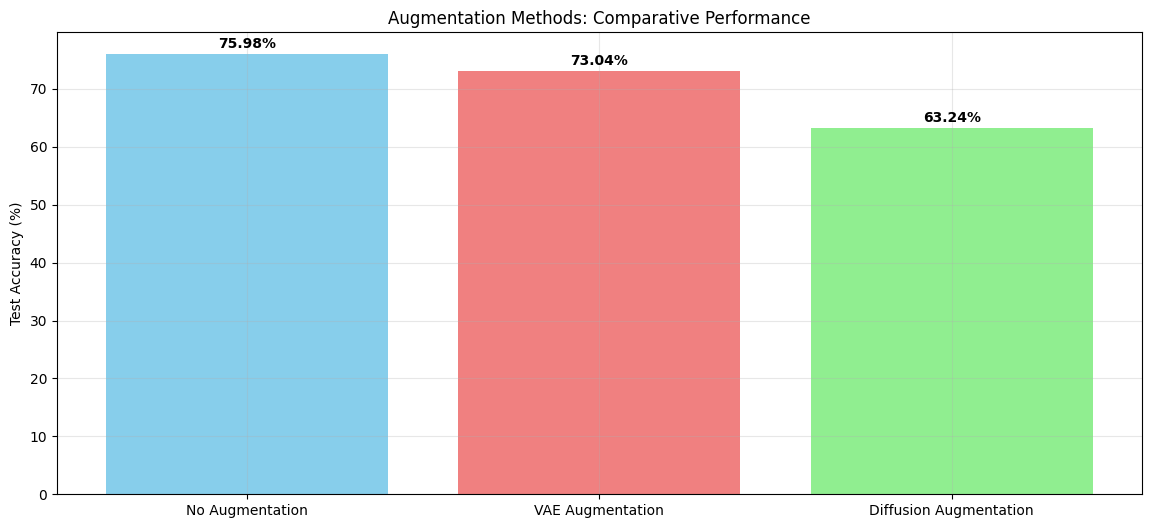

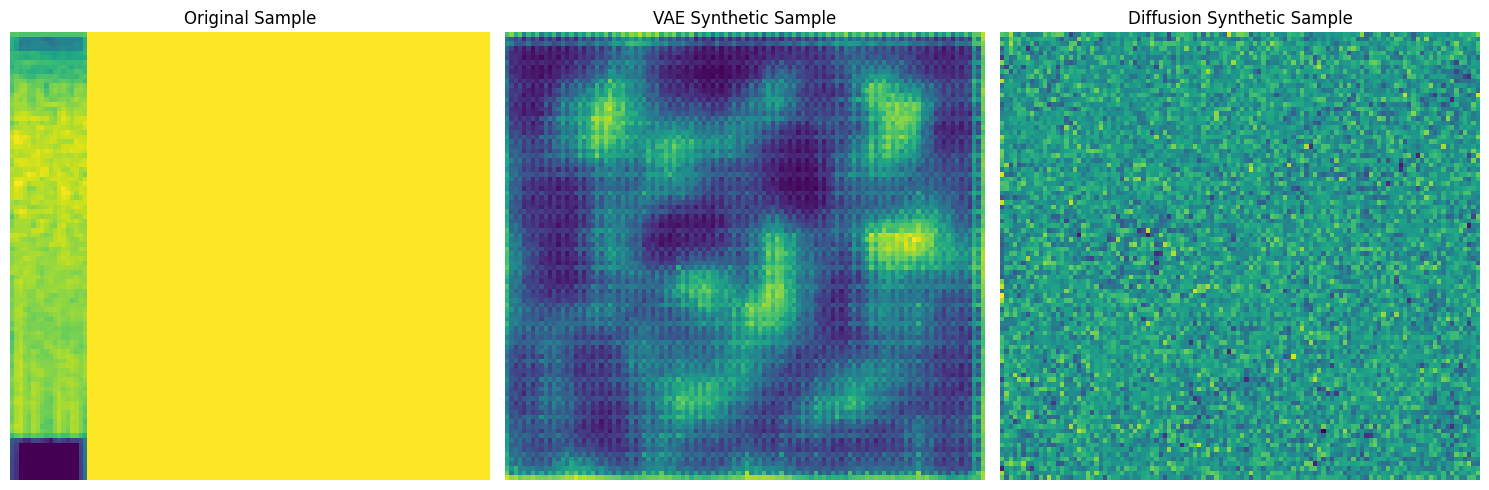

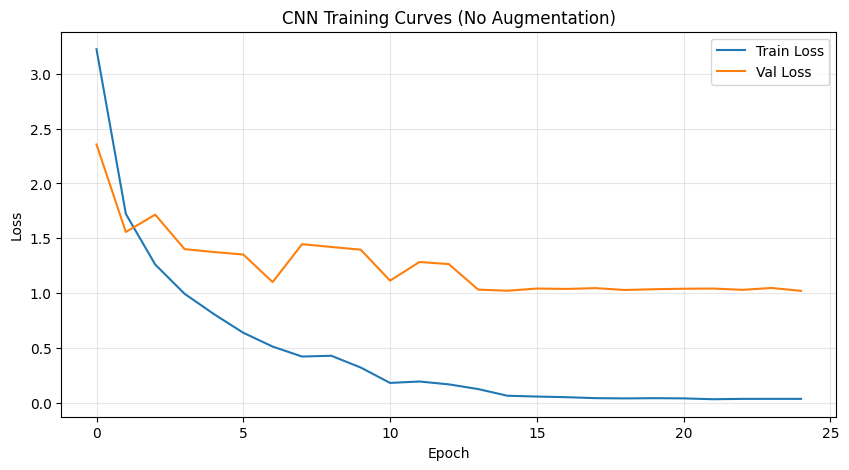

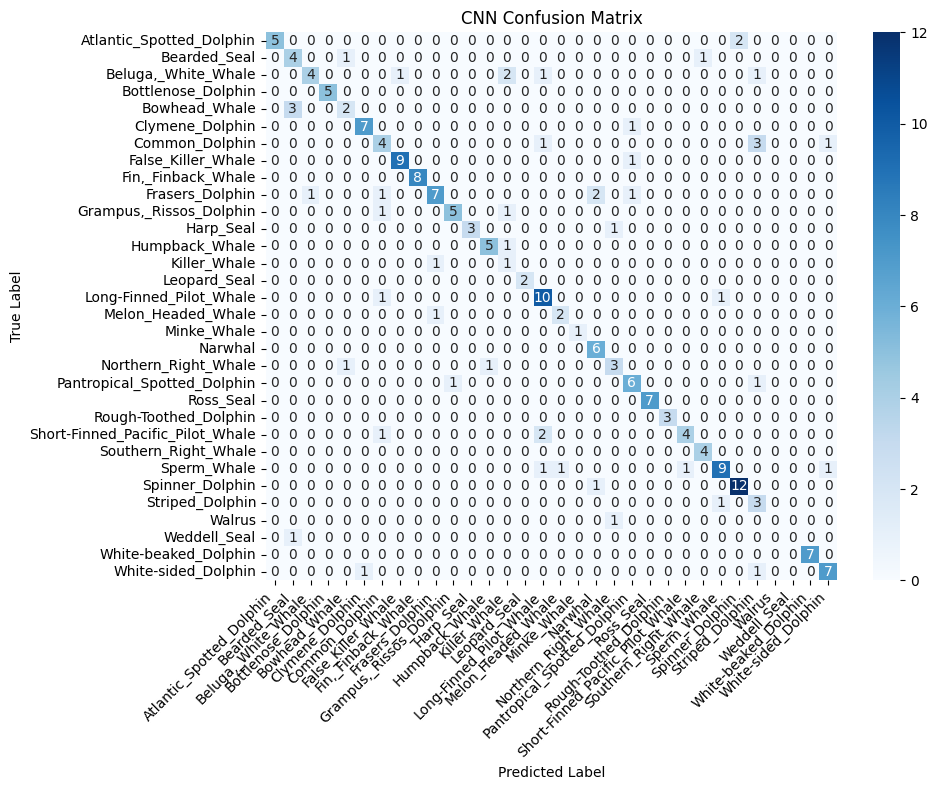

In [42]:
print("\n" + "="*60)
print("COMPARATIVE ANALYSIS OF MODELS AND AUGMENTATION METHODS")
print("="*60)

# Prepare augmentation comparison
augmentation_comparison = []
for model_name, result in results.items():
    if 'vae' in model_name.lower() and 'aug' in model_name.lower():
        aug_method = 'VAE'
        base_model = result.get('base_model', model_name.split('_')[0])
    elif 'diffusion_aug' in model_name.lower():
        aug_method = 'Diffusion'
        base_model = result.get('base_model', model_name.split('_')[0])
    else:
        aug_method = 'None'
        base_model = model_name

    augmentation_comparison.append({
        'Augmentation Method': aug_method,
        'Base Model': base_model,
        'Test Accuracy': result['test_accuracy'],
        'Test Loss': result['test_loss']
    })

aug_df = pd.DataFrame(augmentation_comparison)

# Helper to safely get best model per augmentation
def get_best_aug_model(aug_df, aug_method):
    df = aug_df[aug_df['Augmentation Method'] == aug_method]
    if len(df) == 0:
        return None
    return df.sort_values('Test Accuracy', ascending=False).iloc[0]

best_no_aug = get_best_aug_model(aug_df, 'None')
best_vae_aug = get_best_aug_model(aug_df, 'VAE')
best_diffusion_aug = get_best_aug_model(aug_df, 'Diffusion')

# Print summary
print("\n=== AUGMENTATION METHODS PERFORMANCE ===")
if best_no_aug is not None:
    print(f"No Augmentation: Best Model = {best_no_aug['Base Model']}, Accuracy = {best_no_aug['Test Accuracy']:.2f}%")
if best_vae_aug is not None:
    print(f"VAE Augmentation: Best Model = {best_vae_aug['Base Model']}, Accuracy = {best_vae_aug['Test Accuracy']:.2f}%"
          f" (Improvement: {best_vae_aug['Test Accuracy'] - best_no_aug['Test Accuracy']:+.2f}%)")
else:
    print("VAE Augmentation: No results found.")
if best_diffusion_aug is not None:
    print(f"Diffusion Augmentation: Best Model = {best_diffusion_aug['Base Model']}, Accuracy = {best_diffusion_aug['Test Accuracy']:.2f}%"
          f" (Improvement: {best_diffusion_aug['Test Accuracy'] - best_no_aug['Test Accuracy']:+.2f}%)")
else:
    print("Diffusion Augmentation: No results found.")

# Visualization: Accuracy comparison across augmentation methods
plt.figure(figsize=(14, 6))
methods = []
accuracies = []

if best_no_aug is not None:
    methods.append('No Augmentation')
    accuracies.append(best_no_aug['Test Accuracy'])
if best_vae_aug is not None:
    methods.append('VAE Augmentation')
    accuracies.append(best_vae_aug['Test Accuracy'])
if best_diffusion_aug is not None:
    methods.append('Diffusion Augmentation')
    accuracies.append(best_diffusion_aug['Test Accuracy'])

bars = plt.bar(methods, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('Test Accuracy (%)')
plt.title('Augmentation Methods: Comparative Performance')
plt.grid(True, alpha=0.3)

# Add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

# Visualize sample spectrograms (original + synthetic)
plt.figure(figsize=(15, 5))
sample_idx = 0

# Original
plt.subplot(1, 3, 1)
plt.imshow(X_train_spec[sample_idx].squeeze(), aspect='auto', cmap='viridis')
plt.title('Original Sample')
plt.axis('off')

# VAE synthetic (if available)
if best_vae_aug is not None:
    try:
        with torch.no_grad():
          z = torch.randn(1, vae_model.fc_mu.out_features).to(device)  # latent vector
          vae_sample = vae_model.decode(z).cpu().numpy() # define or use existing function
        plt.subplot(1, 3, 2)
        plt.imshow(vae_sample.squeeze(), aspect='auto', cmap='viridis')
        plt.title('VAE Synthetic Sample')
        plt.axis('off')
    except:
        print("VAE sample generation failed or not implemented.")
else:
    plt.subplot(1, 3, 2)
    plt.text(0.5, 0.5, 'No VAE Data', ha='center', va='center', fontsize=12)
    plt.axis('off')

# Diffusion synthetic (if available)
if best_diffusion_aug is not None:
    try:
        diff_sample = generate_diffusion_samples(diffusion_model, class_label=0, num_samples=1, device=device)
        plt.subplot(1, 3, 3)
        plt.imshow(diff_sample[0].squeeze(), aspect='auto', cmap='viridis')
        plt.title('Diffusion Synthetic Sample')
        plt.axis('off')
    except:
        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, 'No Diffusion Data', ha='center', va='center', fontsize=12)
        plt.axis('off')
else:
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, 'No Diffusion Data', ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Training curves for best model (no augmentation)
if best_no_aug is not None:
    best_model_name = best_no_aug['Base Model']
    best_result = results[best_model_name]
    if 'train_history' in best_result:
        train_losses, train_accs, val_losses, val_accs = best_result['train_history']
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{best_model_name} Training Curves (No Augmentation)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Confusion matrix for best model
if best_no_aug is not None and 'predictions' in best_result:
    best_preds = best_result['predictions']
    best_true = best_result['true_labels']

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(best_true, best_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{best_model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
